# Task 1: Domain Adaptation Techniques

In [1]:
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Subset
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import SGD
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torchvision
import torch
import os


## Loading PACS

In [2]:
if not os.path.isdir('./Homework3-PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

transf = transforms.Compose([
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(means,stds)
])

DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ART = 'Homework3-PACS/PACS/art_painting'
DIR_CARTOON = 'Homework3-PACS/PACS/cartoon'
DIR_SKETCH = 'Homework3-PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

domains = {
    'photo': photo_dataset,
    'art_painting': art_dataset,
    'cartoon': cartoon_dataset,
    'sketch': sketch_dataset
}

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032 (from 1)
Receiving objects: 100% (10032/10032), 174.13 MiB | 25.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (9993/9993), done.


### Visualization

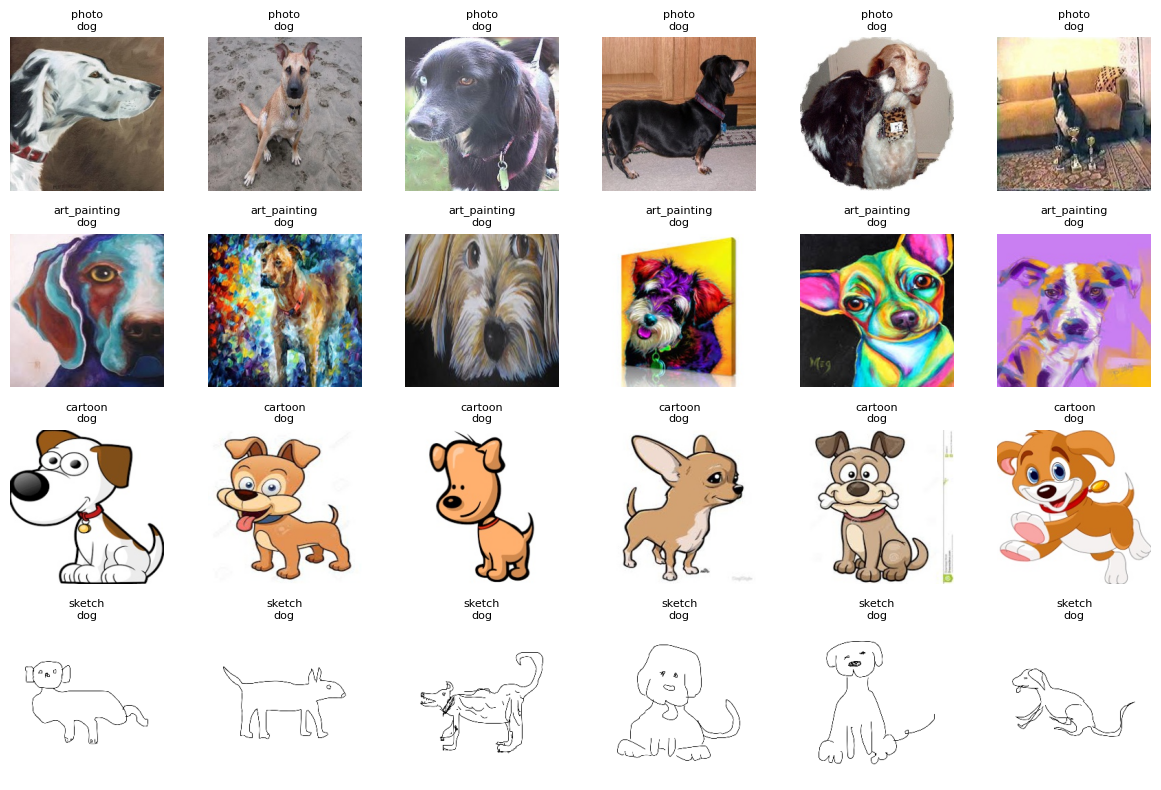

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 6, figsize=(12, 8))
for i, (name, dataset) in enumerate(domains.items()):
    for j in range(6):
        img, label = dataset[j]
        img = img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.clamp(0, 1)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{name}\n{dataset.classes[label]}", fontsize=8)
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


📁 Domain: photo
  dog        :  189 images
  elephant   :  202 images
  giraffe    :  182 images
  guitar     :  186 images
  horse      :  199 images
  house      :  280 images
  person     :  432 images

📁 Domain: art_painting
  dog        :  379 images
  elephant   :  255 images
  giraffe    :  285 images
  guitar     :  184 images
  horse      :  201 images
  house      :  295 images
  person     :  449 images

📁 Domain: cartoon
  dog        :  389 images
  elephant   :  457 images
  giraffe    :  346 images
  guitar     :  135 images
  horse      :  324 images
  house      :  288 images
  person     :  405 images

📁 Domain: sketch
  dog        :  772 images
  elephant   :  740 images
  giraffe    :  753 images
  guitar     :  608 images
  horse      :  816 images
  house      :   80 images
  person     :  160 images


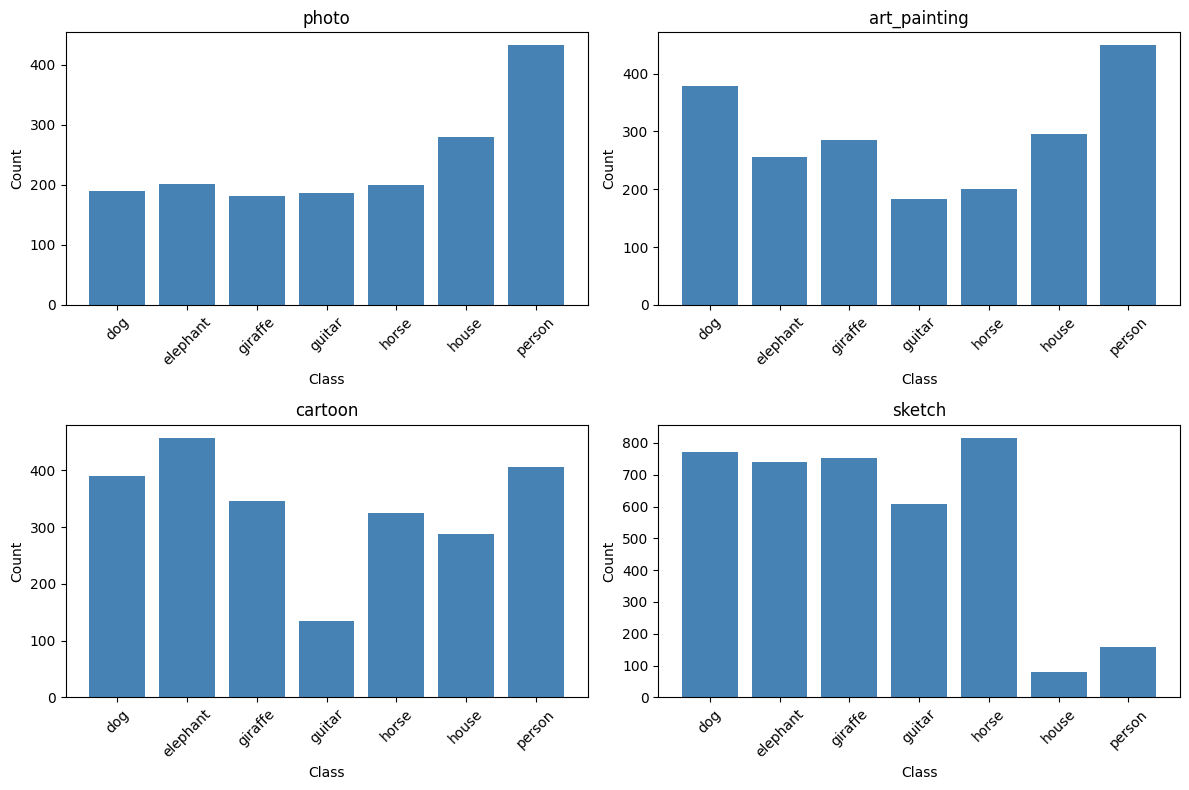

In [4]:
for domain_name, dataset in domains.items():
    class_counts = Counter([label for _, label in dataset.samples])
    class_counts = dict(sorted(class_counts.items()))

    print(f"\n📁 Domain: {domain_name}")
    for i, cls_name in enumerate(dataset.classes):
        print(f"  {cls_name:10s} : {class_counts[i]:4d} images")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (domain_name, dataset) in enumerate(domains.items()):
    class_counts = Counter([label for _, label in dataset.samples])
    class_counts = dict(sorted(class_counts.items()))
    counts = [class_counts[i] for i in range(len(dataset.classes))]

    axes[i].bar(dataset.classes, counts, color='steelblue')
    axes[i].set_title(domain_name)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Initialization

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import datasets

labels = np.array([s[1] for s in art_dataset.samples])
train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    random_state=42,
    stratify=labels
)

art_train = Subset(art_dataset, train_idx)
art_test = Subset(datasets.ImageFolder(DIR_ART, transform=transf), test_idx)

labels_cartoon = np.array([s[1] for s in cartoon_dataset.samples])
train_idx_cartoon, test_idx_cartoon = train_test_split(
    np.arange(len(labels_cartoon)),
    test_size=0.2,
    random_state=42,
    stratify=labels_cartoon
)

cartoon_train = Subset(cartoon_dataset, train_idx_cartoon)
cartoon_test = Subset(datasets.ImageFolder(DIR_CARTOON, transform=transf), test_idx_cartoon)



batch_size = 32

art_train_loader = DataLoader(art_train, batch_size=batch_size, shuffle=True, drop_last = True)
art_test_loader = DataLoader(art_test, batch_size=batch_size, shuffle=False)
cartoon_train_loader = DataLoader(cartoon_train, batch_size=batch_size, shuffle=True, drop_last = True)
cartoon_test_loader = DataLoader(cartoon_test, batch_size=batch_size, shuffle=False)

print(f"Art total: {len(art_dataset)}, train: {len(art_train)}, test: {len(art_test)}")
print(f"Cartoon total: {len(cartoon_dataset)}, train: {len(cartoon_train)}, test: {len(cartoon_test)}")

print("Dataloaders ready:")
print(f"  - Source train batches: {len(art_train_loader)}")
print(f"  - Source test batches:  {len(art_test_loader)}")
print(f"  - Target train batches: {len(cartoon_train_loader)}")
print(f"  - Target test batches:  {len(cartoon_test_loader)}")


Art total: 2048, train: 1638, test: 410
Cartoon total: 2344, train: 1875, test: 469
Dataloaders ready:
  - Source train batches: 51
  - Source test batches:  13
  - Target train batches: 58
  - Target test batches:  15


## Task 1.1: Source-Only Baseline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_classes = len(art_dataset.classes)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD([
    {'params': model.fc.parameters(), 'lr': 0.01},
    {'params': model.layer1.parameters()},
    {'params': model.layer2.parameters()},
    {'params': model.layer3.parameters()},
    {'params': model.layer4.parameters()},
    {'params': model.conv1.parameters()},
    {'params': model.bn1.parameters()},
], lr=1e-3, momentum=0.9)


Device: cuda


In [ ]:
n_epochs = 10

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

for epoch in range(1, n_epochs+1):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    loop = tqdm(art_train_loader, desc=f"Epoch {epoch}/{n_epochs}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)
        loop.set_postfix(loss=running_loss/running_total, acc=running_correct/running_total)

    train_acc = running_correct / running_total
    val_acc = evaluate(model, art_test_loader)

    print(f"Epoch {epoch:02d} — Train Accuracy (Art): {train_acc:.3f} | Validation Accuracy (Art): {val_acc:.3f}")

Epoch 1/10: 100%|██████████| 51/51 [00:07<00:00,  6.79it/s, acc=0.703, loss=0.83]


Epoch 01 — Train Accuracy (Art): 0.703 | Validation Accuracy (Art): 0.871


Epoch 2/10: 100%|██████████| 51/51 [00:07<00:00,  7.15it/s, acc=0.959, loss=0.136]


Epoch 02 — Train Accuracy (Art): 0.959 | Validation Accuracy (Art): 0.912


Epoch 3/10: 100%|██████████| 51/51 [00:07<00:00,  6.98it/s, acc=0.984, loss=0.0554]


Epoch 03 — Train Accuracy (Art): 0.984 | Validation Accuracy (Art): 0.907


Epoch 4/10: 100%|██████████| 51/51 [00:07<00:00,  6.92it/s, acc=0.997, loss=0.0226]


Epoch 04 — Train Accuracy (Art): 0.997 | Validation Accuracy (Art): 0.907


Epoch 5/10: 100%|██████████| 51/51 [00:07<00:00,  7.13it/s, acc=0.998, loss=0.0167]


Epoch 05 — Train Accuracy (Art): 0.998 | Validation Accuracy (Art): 0.920


Epoch 6/10: 100%|██████████| 51/51 [00:07<00:00,  7.05it/s, acc=0.998, loss=0.0104]


Epoch 06 — Train Accuracy (Art): 0.998 | Validation Accuracy (Art): 0.922


Epoch 7/10: 100%|██████████| 51/51 [00:07<00:00,  6.92it/s, acc=1, loss=0.00545]


Epoch 07 — Train Accuracy (Art): 1.000 | Validation Accuracy (Art): 0.915


Epoch 8/10: 100%|██████████| 51/51 [00:07<00:00,  7.08it/s, acc=1, loss=0.00505]


Epoch 08 — Train Accuracy (Art): 1.000 | Validation Accuracy (Art): 0.912


Epoch 9/10: 100%|██████████| 51/51 [00:07<00:00,  7.10it/s, acc=1, loss=0.00573]


Epoch 09 — Train Accuracy (Art): 1.000 | Validation Accuracy (Art): 0.910


Epoch 10/10: 100%|██████████| 51/51 [00:07<00:00,  6.88it/s, acc=0.999, loss=0.00422]


Epoch 10 — Train Accuracy (Art): 0.999 | Validation Accuracy (Art): 0.920


In [ ]:
cartoon_accuracy = evaluate(model, cartoon_test_loader)
print(f"Accuracy on Cartoon: {cartoon_accuracy:.3f}")

Accuracy on Cartoon: 0.539


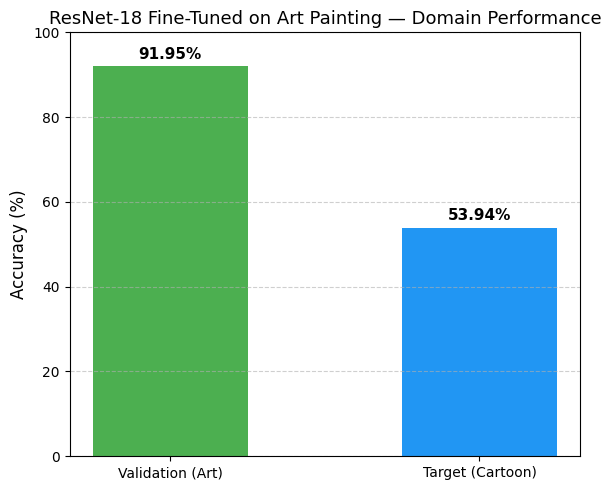

In [ ]:
art_acc = evaluate(model, art_test_loader)
cartoon_acc = evaluate(model, cartoon_test_loader)

val_acc_percent = art_acc * 100
cartoon_acc_percent = cartoon_acc * 100

labels = ['Validation (Art)', 'Target (Cartoon)']
values = [val_acc_percent, cartoon_acc_percent]
colors = ['#4CAF50', '#2196F3']

plt.figure(figsize=(6,5))
bars = plt.bar(labels, values, color=colors, width=0.5)
plt.title('ResNet-18 Fine-Tuned on Art Painting — Domain Performance', fontsize=13)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'resnet18_source_only_baseline.pth')

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet18FeatureExtractor(nn.Module):
    """
    Loads a ResNet-18 model and returns feature vectors before the final FC layer.
    Can optionally load a fine-tuned state_dict directly.
    """
    def __init__(self, num_classes=7, state_dict=None, device='cpu', pretrained=True):
        super().__init__()

        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet18(weights=weights)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

        if state_dict is not None:
            self.backbone.load_state_dict(state_dict)
            print("✅ Loaded fine-tuned weights from provided state_dict.")

        self.feature_extractor = nn.Sequential(*list(self.backbone.children())[:-1])
        self.feature_extractor.to(device)
        self.device = device

    def forward(self, x):
        with torch.no_grad():
            feats = self.feature_extractor(x.to(self.device))
            feats = feats.view(feats.size(0), -1)
        return feats


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = model.state_dict()
extractor = ResNet18FeatureExtractor(
    num_classes=len(art_dataset.classes),
    state_dict=state_dict,
    device=device,
    pretrained=False
)

extractor.eval()
print("✅ Feature extractor ready, using current fine-tuned model weights.")

✅ Loaded fine-tuned weights from provided state_dict.
✅ Feature extractor ready, using current fine-tuned model weights.


In [ ]:
from tqdm import tqdm

def get_features_and_labels(loader, extractor):
    feats, labels = [], []
    for imgs, lbls in tqdm(loader, desc="Extracting features"):
        with torch.no_grad():
            imgs = imgs.to(extractor.device)
            f = extractor(imgs)
        feats.append(f.cpu())
        labels.append(lbls)
    feats = torch.cat(feats)
    labels = torch.cat(labels)
    return feats, labels

art_feats, art_labels = get_features_and_labels(art_test_loader, extractor)
cartoon_feats, cartoon_labels = get_features_and_labels(cartoon_test_loader, extractor)

Extracting features: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


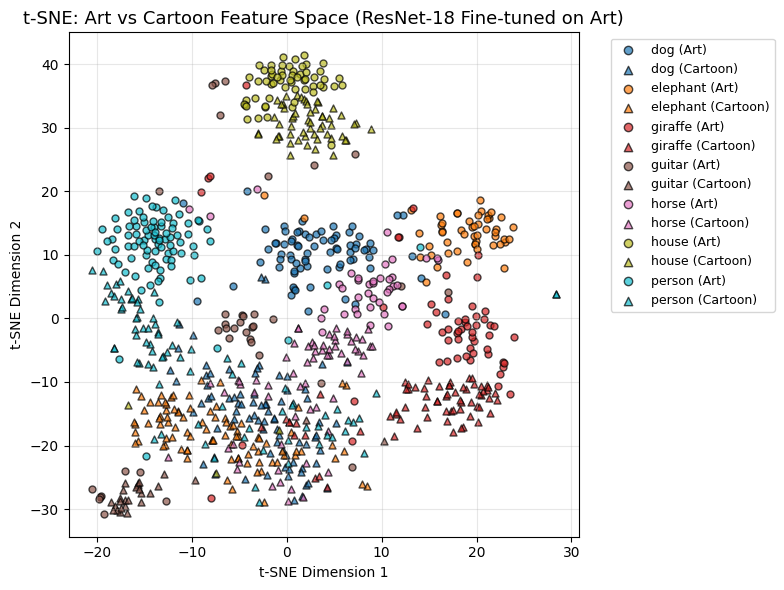

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

X = torch.cat([art_feats, cartoon_feats]).numpy()
y_class = torch.cat([art_labels, cartoon_labels]).numpy()
y_domain = np.array([0]*len(art_feats) + [1]*len(cartoon_feats))

tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)

num_classes = len(art_dataset.classes)
class_names = art_dataset.classes
palette = plt.cm.tab10(np.linspace(0, 1, num_classes))

markers = {0: 'o', 1: '^'}
domain_labels = {0: 'Art', 1: 'Cartoon'}

plt.figure(figsize=(8, 6))

for cls_idx in range(num_classes):
    for domain in [0, 1]:
        mask = (y_class == cls_idx) & (y_domain == domain)
        plt.scatter(
            X_2d[mask, 0], X_2d[mask, 1],
            s=25,
            c=[palette[cls_idx]],
            marker=markers[domain],
            edgecolor='k',
            alpha=0.7,
            label=f"{class_names[cls_idx]} ({domain_labels[domain]})"
        )

plt.title("t-SNE: Art vs Cartoon Feature Space (ResNet-18 Fine-tuned on Art)", fontsize=13)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1.2, fontsize=9)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Running t-SNE on 500 samples per domain...


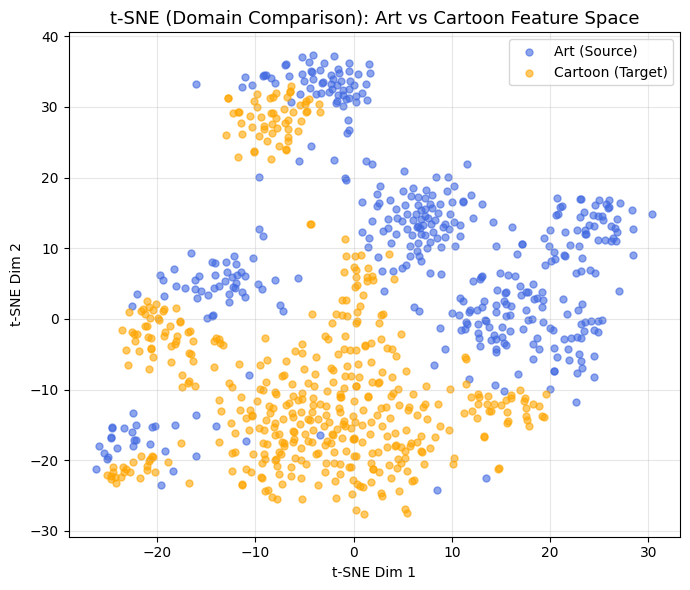

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch

art_X = art_feats.numpy()
cartoon_X = cartoon_feats.numpy()

n_samples = 500
art_idx = np.random.choice(len(art_X), size=min(n_samples, len(art_X)), replace=False)
cartoon_idx = np.random.choice(len(cartoon_X), size=min(n_samples, len(cartoon_X)), replace=False)

art_X = art_X[art_idx]
cartoon_X = cartoon_X[cartoon_idx]

X = np.concatenate([art_X, cartoon_X], axis=0)
y_domain = np.array([0]*len(art_X) + [1]*len(cartoon_X))  # 0=Art, 1=Cartoon

print("Running t-SNE on 500 samples per domain...")
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[y_domain==0, 0], X_2d[y_domain==0, 1],
            s=25, c='royalblue', alpha=0.6, label='Art (Source)')
plt.scatter(X_2d[y_domain==1, 0], X_2d[y_domain==1, 1],
            s=25, c='orange', alpha=0.6, label='Cartoon (Target)')

plt.title("t-SNE (Domain Comparison): Art vs Cartoon Feature Space", fontsize=13)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Training for T-SNE Silhouette

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_classes = len(art_dataset.classes)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD([
    {'params': model.fc.parameters(), 'lr': 0.01},         # classifier head
    {'params': model.layer1.parameters()},
    {'params': model.layer2.parameters()},
    {'params': model.layer3.parameters()},
    {'params': model.layer4.parameters()},
    {'params': model.conv1.parameters()},
    {'params': model.bn1.parameters()},
], lr=1e-3, momentum=0.9)


Device: cuda


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet18FeatureExtractor(nn.Module):
    """
    Loads a ResNet-18 model and returns feature vectors before the final FC layer.
    Can optionally load a fine-tuned state_dict directly.
    """
    def __init__(self, num_classes=7, state_dict=None, device='cpu', pretrained=True):
        super().__init__()

        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet18(weights=weights)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

        if state_dict is not None:
            self.backbone.load_state_dict(state_dict)
            print("✅ Loaded fine-tuned weights from provided state_dict.")

        self.feature_extractor = nn.Sequential(*list(self.backbone.children())[:-1])
        self.feature_extractor.to(device)
        self.device = device

    def forward(self, x):
        with torch.no_grad():
            feats = self.feature_extractor(x.to(self.device))
            feats = feats.view(feats.size(0), -1)
        return feats


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = model.state_dict()
extractor = ResNet18FeatureExtractor(
    num_classes=len(art_dataset.classes),
    state_dict=state_dict,
    device=device,
    pretrained=False
)

extractor.eval()
print("✅ Feature extractor ready, using current fine-tuned model weights.")

✅ Loaded fine-tuned weights from provided state_dict.
✅ Feature extractor ready, using current fine-tuned model weights.


In [ ]:
n_epochs = 10

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

for epoch in range(1, n_epochs+1):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    loop = tqdm(art_train_loader, desc=f"Epoch {epoch}/{n_epochs}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)
        loop.set_postfix(loss=running_loss/running_total, acc=running_correct/running_total)

    train_acc = running_correct / running_total
    val_acc = evaluate(model, art_test_loader)

    print(f"Epoch {epoch:02d} — Train Accuracy (Art): {train_acc:.3f} | Validation Accuracy (Art): {val_acc:.3f}")

Epoch 1/10: 100%|██████████| 51/51 [00:08<00:00,  6.20it/s, acc=0.711, loss=0.804]


Epoch 01 — Train Accuracy (Art): 0.711 | Validation Accuracy (Art): 0.900


Epoch 2/10: 100%|██████████| 51/51 [00:07<00:00,  6.80it/s, acc=0.95, loss=0.137]


Epoch 02 — Train Accuracy (Art): 0.950 | Validation Accuracy (Art): 0.907


Epoch 3/10: 100%|██████████| 51/51 [00:07<00:00,  7.16it/s, acc=0.988, loss=0.0444]


Epoch 03 — Train Accuracy (Art): 0.988 | Validation Accuracy (Art): 0.912


Epoch 4/10: 100%|██████████| 51/51 [00:07<00:00,  6.82it/s, acc=0.997, loss=0.0162]


Epoch 04 — Train Accuracy (Art): 0.997 | Validation Accuracy (Art): 0.917


Epoch 5/10: 100%|██████████| 51/51 [00:07<00:00,  6.83it/s, acc=0.996, loss=0.0193]


Epoch 05 — Train Accuracy (Art): 0.996 | Validation Accuracy (Art): 0.912


Epoch 6/10: 100%|██████████| 51/51 [00:07<00:00,  7.11it/s, acc=0.999, loss=0.0102]


Epoch 06 — Train Accuracy (Art): 0.999 | Validation Accuracy (Art): 0.917


Epoch 7/10: 100%|██████████| 51/51 [00:07<00:00,  6.72it/s, acc=1, loss=0.00757]


Epoch 07 — Train Accuracy (Art): 1.000 | Validation Accuracy (Art): 0.920


Epoch 8/10: 100%|██████████| 51/51 [00:08<00:00,  5.94it/s, acc=0.998, loss=0.00849]


Epoch 08 — Train Accuracy (Art): 0.998 | Validation Accuracy (Art): 0.910


Epoch 9/10: 100%|██████████| 51/51 [00:07<00:00,  6.91it/s, acc=1, loss=0.00627]


Epoch 09 — Train Accuracy (Art): 1.000 | Validation Accuracy (Art): 0.922


Epoch 10/10: 100%|██████████| 51/51 [00:07<00:00,  7.07it/s, acc=1, loss=0.00545]


Epoch 10 — Train Accuracy (Art): 1.000 | Validation Accuracy (Art): 0.910


### Old Visualization (on Train Loader)

In [ ]:
from tqdm import tqdm

def get_features_and_labels(loader, extractor):
    feats, labels = [], []
    for imgs, lbls in tqdm(loader, desc="Extracting features"):
        with torch.no_grad():
            imgs = imgs.to(extractor.device)
            f = extractor(imgs)
        feats.append(f.cpu())
        labels.append(lbls)
    feats = torch.cat(feats)
    labels = torch.cat(labels)
    return feats, labels


art_feats, art_labels = get_features_and_labels(art_train_loader, extractor)
cartoon_feats, cartoon_labels = get_features_and_labels(cartoon_train_loader, extractor)

Extracting features: 100%|██████████| 74/74 [00:06<00:00, 11.75it/s]


Running t-SNE... (this may take 1–3 minutes)


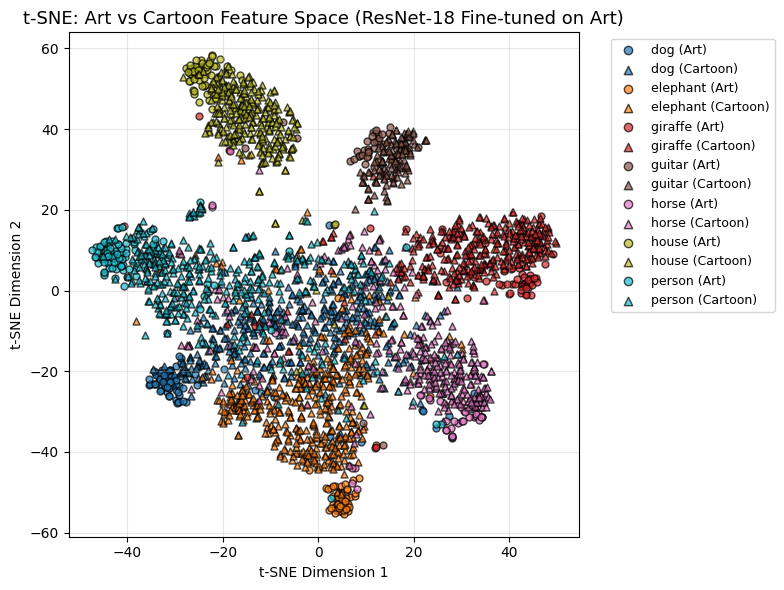

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

X = torch.cat([art_feats, cartoon_feats]).numpy()
y_class = torch.cat([art_labels, cartoon_labels]).numpy()
y_domain = np.array([0]*len(art_feats) + [1]*len(cartoon_feats))  
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)

num_classes = len(art_dataset.classes)
class_names = art_dataset.classes
palette = plt.cm.tab10(np.linspace(0, 1, num_classes))  
markers = {0: 'o', 1: '^'}  domain_labels = {0: 'Art', 1: 'Cartoon'}

plt.figure(figsize=(8, 6))

for cls_idx in range(num_classes):
    for domain in [0, 1]:
        mask = (y_class == cls_idx) & (y_domain == domain)
        plt.scatter(
            X_2d[mask, 0], X_2d[mask, 1],
            s=25,
            c=[palette[cls_idx]],
            marker=markers[domain],
            edgecolor='k',
            alpha=0.7,
            label=f"{class_names[cls_idx]} ({domain_labels[domain]})"
        )

plt.title("t-SNE: Art vs Cartoon Feature Space (ResNet-18 Fine-tuned on Art)", fontsize=13)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1.2, fontsize=9)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Running t-SNE on a subset of 500 samples per domain...


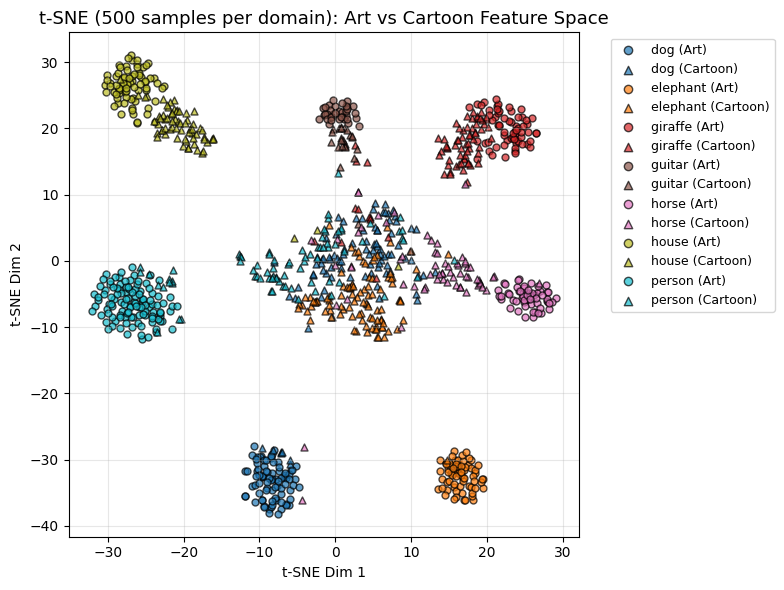

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch

art_X = art_feats.numpy()
cartoon_X = cartoon_feats.numpy()
art_y = art_labels.numpy()
cartoon_y = cartoon_labels.numpy()

n_samples = 500
art_idx = np.random.choice(len(art_X), size=min(n_samples, len(art_X)), replace=False)
cartoon_idx = np.random.choice(len(cartoon_X), size=min(n_samples, len(cartoon_X)), replace=False)

art_X, art_y = art_X[art_idx], art_y[art_idx]
cartoon_X, cartoon_y = cartoon_X[cartoon_idx], cartoon_y[cartoon_idx]

X = np.concatenate([art_X, cartoon_X], axis=0)
y_class = np.concatenate([art_y, cartoon_y], axis=0)
y_domain = np.array([0]*len(art_X) + [1]*len(cartoon_X))  
print("Running t-SNE on a subset of 500 samples per domain...")
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

num_classes = len(art_dataset.classes)
class_names = art_dataset.classes
palette = plt.cm.tab10(np.linspace(0, 1, num_classes))

markers = {0: 'o', 1: '^'}  domain_labels = {0: 'Art', 1: 'Cartoon'}

plt.figure(figsize=(8, 6))
for cls_idx in range(num_classes):
    for domain in [0, 1]:
        mask = (y_class == cls_idx) & (y_domain == domain)
        plt.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            s=25,
            c=[palette[cls_idx]],
            marker=markers[domain],
            edgecolor='k',
            alpha=0.7,
            label=f"{class_names[cls_idx]} ({domain_labels[domain]})"
        )

plt.title("t-SNE (500 samples per domain): Art vs Cartoon Feature Space", fontsize=13)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=1.2, fontsize=9)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Running t-SNE on 500 samples per domain...


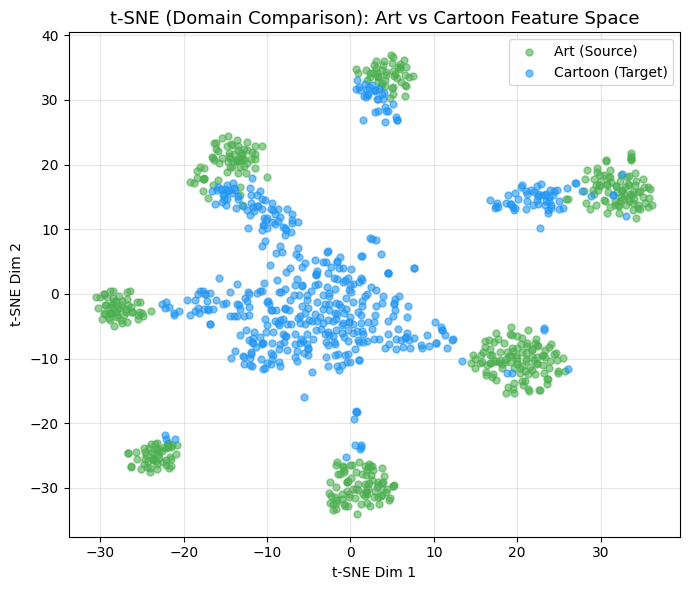

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch

art_X = art_feats.numpy()
cartoon_X = cartoon_feats.numpy()

n_samples = 500
art_idx = np.random.choice(len(art_X), size=min(n_samples, len(art_X)), replace=False)
cartoon_idx = np.random.choice(len(cartoon_X), size=min(n_samples, len(cartoon_X)), replace=False)

art_X = art_X[art_idx]
cartoon_X = cartoon_X[cartoon_idx]


X = np.concatenate([art_X, cartoon_X], axis=0)
y_domain = np.array([0]*len(art_X) + [1]*len(cartoon_X))  
print("Running t-SNE on 500 samples per domain...")
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[y_domain==0, 0], X_2d[y_domain==0, 1],
            s=25, c='plt.scatter(X_2d[y_domain==1, 0], X_2d[y_domain==1, 1],
            s=25, c='
plt.title("t-SNE (Domain Comparison): Art vs Cartoon Feature Space", fontsize=13)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Task 1.2: Domain Adaptation Techniques

### DAN

In [ ]:
!pip install dalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
from dalib.modules.kernels import GaussianKernel
from dalib.adaptation.dan import MultipleKernelMaximumMeanDiscrepancy
from dalib.adaptation.dan import ImageClassifier

In [ ]:
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7

backbone = ResNet18FeatureExtractor(pretrained=True)
classifier = ImageClassifier(backbone, num_classes).to(device)

bandwidths = [2 ** i for i in np.arange(-8, 9, 0.5)]
kernels = [GaussianKernel(alpha=gamma) for gamma in bandwidths]
mkmmd_loss = MultipleKernelMaximumMeanDiscrepancy(kernels=kernels).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [ ]:
params = [
    {"params": [p for n, p in classifier.backbone.named_parameters() if p.requires_grad], "lr": 0.001},
    {"params": classifier.head.parameters(), "lr": 0.01},  optimizer = SGD(params, momentum=0.9, weight_decay=1e-3, nesterov=True)

In [ ]:
def make_infinite(loader):
    while True:
        for data in loader:
            yield data

train_source_iter = make_infinite(art_train_loader)
train_target_iter = make_infinite(cartoon_train_loader)


def train_one_epoch_dan(train_source_iter, train_target_iter, model, mkmmd_loss, optimizer, steps_per_epoch=100):
    model.train()
    total_loss = 0.0

    for _ in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        y_t, f_t = model(x_t)

        cls_loss = F.cross_entropy(y_s, labels_s)
        transfer_loss = mkmmd_loss(f_s, f_t)
        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / steps_per_epoch

@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total * 100.0


In [ ]:
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    avg_loss = train_one_epoch_dan(train_source_iter, train_target_iter, classifier, mkmmd_loss, optimizer)
    acc = evaluate(cartoon_test_loader, classifier)
    source_acc = evaluate(art_test_loader, classifier)
    best_acc = max(best_acc, acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Source Acc {source_acc:.2f} | Target Acc: {acc:.2f}% | Best: {best_acc:.2f}%")

print("Training complete.")


Epoch [1/10] | Loss: 1.2594 | Source Acc 84.15 | Target Acc: 61.19% | Best: 61.19%
Epoch [2/10] | Loss: 0.3637 | Source Acc 87.80 | Target Acc: 63.97% | Best: 63.97%
Epoch [3/10] | Loss: 0.1879 | Source Acc 88.29 | Target Acc: 69.72% | Best: 69.72%
Epoch [4/10] | Loss: 0.0975 | Source Acc 89.27 | Target Acc: 70.58% | Best: 70.58%
Epoch [5/10] | Loss: 0.0743 | Source Acc 89.02 | Target Acc: 69.72% | Best: 70.58%
Epoch [6/10] | Loss: 0.0564 | Source Acc 88.29 | Target Acc: 73.13% | Best: 73.13%
Epoch [7/10] | Loss: 0.0486 | Source Acc 88.78 | Target Acc: 73.13% | Best: 73.13%
Epoch [8/10] | Loss: 0.0423 | Source Acc 89.27 | Target Acc: 74.63% | Best: 74.63%
Epoch [9/10] | Loss: 0.0396 | Source Acc 89.76 | Target Acc: 74.63% | Best: 74.63%
Epoch [10/10] | Loss: 0.0326 | Source Acc 89.51 | Target Acc: 74.63% | Best: 74.63%
Training complete.


#### t-SNE Visualization of Features (Domain-wise)

Running t-SNE on 879 samples:


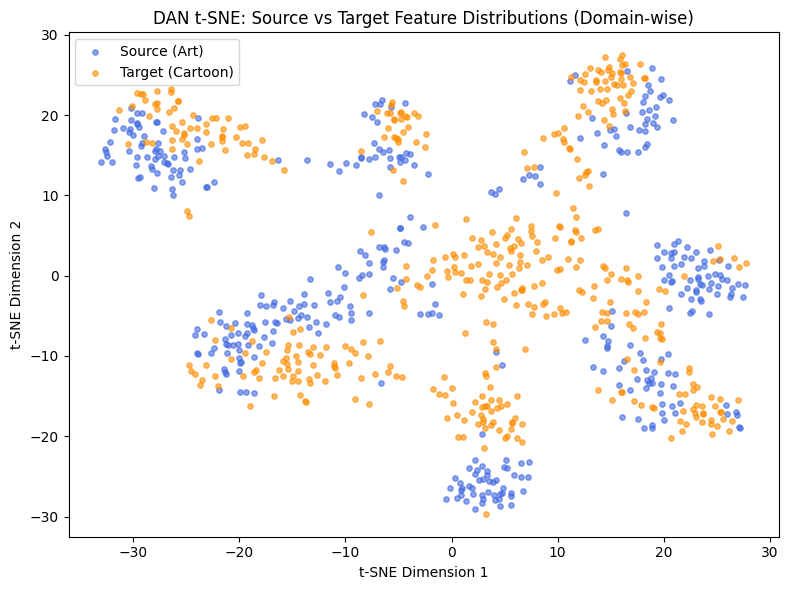

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=500):
    """Extract up to `max_samples` features + domain label (0=source, 1=target)."""
    model.eval()
    feats, domains = [], []
    count = 0

    for x, _ in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        domains.append(torch.full((f.size(0),), domain_label))
        count += f.size(0)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, domains


src_feats, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

# --- Combine ---
all_feats = torch.cat([src_feats, tgt_feats])
all_domains = torch.cat([src_domains, tgt_domains])

print(f"Running t-SNE on {len(all_feats)} samples:")
feats_np = all_feats.numpy()
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(feats_np)

plt.figure(figsize=(8, 6))
plt.scatter(
    feats_2d[all_domains == 0, 0],
    feats_2d[all_domains == 0, 1],
    c='royalblue', label='Source (Art)', alpha=0.6, s=15
)
plt.scatter(
    feats_2d[all_domains == 1, 0],
    feats_2d[all_domains == 1, 1],
    c='darkorange', label='Target (Cartoon)', alpha=0.6, s=15
)
plt.legend()
plt.title("DAN t-SNE: Source vs Target Feature Distributions (Domain-wise)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()


#### t-SNE Visualization of Features (Class-wise)

Running t-SNE on 879 samples:


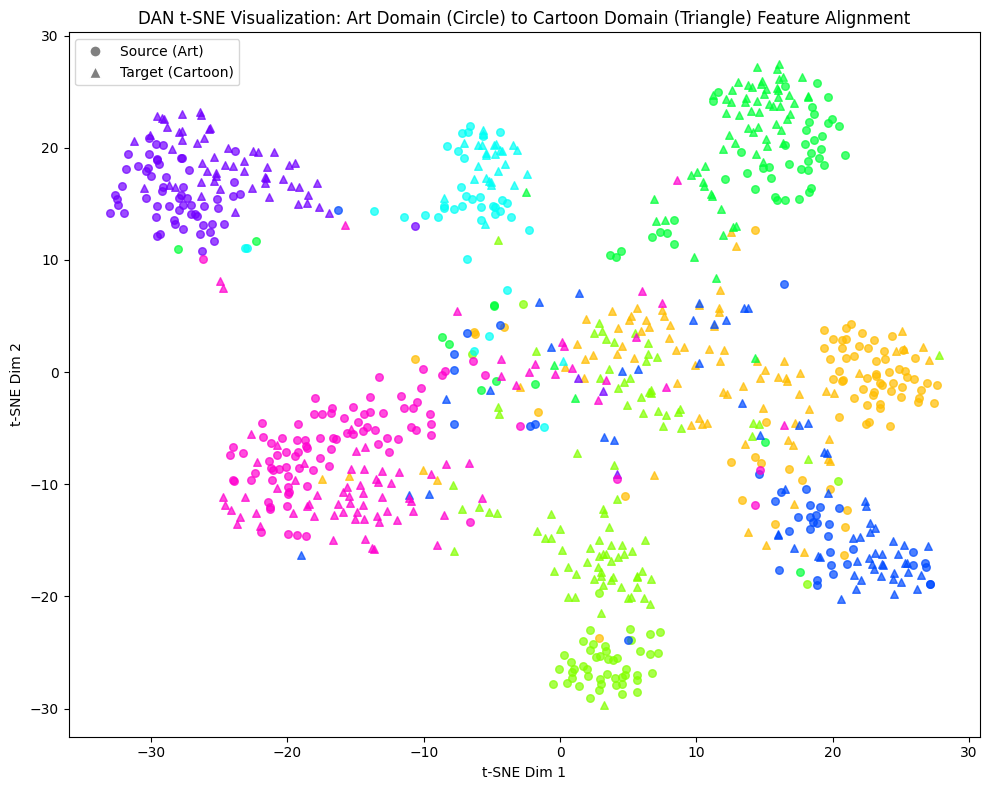

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=250):

    model.eval()
    feats, labels, domains = [], [], []
    count = 0

    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))

        count += len(x)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    labels = torch.cat(labels)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, labels, domains


src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print(f"Running t-SNE on {len(all_feats)} samples:")
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(all_feats.numpy())

labels_np = all_labels.numpy()
domains_np = all_domains.numpy()

num_classes = len(np.unique(labels_np))
palette = sns.color_palette("hsv", num_classes)

plt.figure(figsize=(10, 8))
for cls in range(num_classes):
    idx_src = np.where((labels_np == cls) & (domains_np == 0))[0]
    idx_tgt = np.where((labels_np == cls) & (domains_np == 1))[0]

    plt.scatter(
        feats_2d[idx_src, 0],
        feats_2d[idx_src, 1],
        color=palette[cls],
        marker='o',
        alpha=0.7,
        s=30
    )
    plt.scatter(
        feats_2d[idx_tgt, 0],
        feats_2d[idx_tgt, 1],
        color=palette[cls],
        marker='^',
        alpha=0.7,
        s=30
    )

plt.title("DAN t-SNE Visualization: Art Domain (Circle) to Cartoon Domain (Triangle) Feature Alignment")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Source (Art)', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Target (Cartoon)', markerfacecolor='gray', markersize=8)
]

plt.legend(handles=legend_elems, loc='best', frameon=True)
plt.tight_layout()
plt.show()


### DAN v2

In [ ]:
!pip install dalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
from dalib.modules.kernels import GaussianKernel
from dalib.adaptation.dan import MultipleKernelMaximumMeanDiscrepancy
from dalib.adaptation.dan import ImageClassifier

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7

backbone = ResNet18FeatureExtractor(pretrained=True)
classifier = ImageClassifier(backbone, num_classes).to(device)

bandwidths = [2 ** i for i in np.arange(-8, 9, 0.5)]
kernels = [GaussianKernel(alpha=gamma) for gamma in bandwidths]
mkmmd_loss = MultipleKernelMaximumMeanDiscrepancy(kernels=kernels).to(device)

def make_infinite(loader):
    while True:
        for data in loader:
            yield data

train_source_iter = make_infinite(art_train_loader)
train_target_iter = make_infinite(cartoon_train_loader)

params = [
    {"params": [p for n, p in classifier.backbone.named_parameters() if p.requires_grad], "lr": 0.001},
    {"params": classifier.head.parameters(), "lr": 0.01},
]

optimizer = SGD(params, momentum=0.9, weight_decay=1e-3, nesterov=True)


def train_one_epoch_dan(train_source_iter, train_target_iter, model, mkmmd_loss, optimizer, steps_per_epoch=100):
    model.train()
    total_loss = 0.0

    for _ in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        y_t, f_t = model(x_t)

        cls_loss = F.cross_entropy(y_s, labels_s)

        f_s = F.normalize(f_s, dim=1)
        f_t = F.normalize(f_t, dim=1)

        transfer_loss = mkmmd_loss(f_s, f_t)
        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / steps_per_epoch

@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total * 100.0


epochs = 20
best_acc = 0.0

for epoch in range(epochs):
    avg_loss = train_one_epoch_dan(train_source_iter, train_target_iter, classifier, mkmmd_loss, optimizer)
    acc = evaluate(cartoon_test_loader, classifier)
    source_acc = evaluate(art_test_loader, classifier)
    best_acc = max(best_acc, acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Source Acc {source_acc:.2f} | Target Acc: {acc:.2f}% | Best: {best_acc:.2f}%")

print("Training complete.")

Epoch [1/20] | Loss: 1.2259 | Source Acc 81.22 | Target Acc: 63.54% | Best: 63.54%
Epoch [2/20] | Loss: 0.3598 | Source Acc 87.07 | Target Acc: 68.02% | Best: 68.02%
Epoch [3/20] | Loss: 0.1784 | Source Acc 87.32 | Target Acc: 70.36% | Best: 70.36%
Epoch [4/20] | Loss: 0.0983 | Source Acc 88.29 | Target Acc: 69.51% | Best: 70.36%
Epoch [5/20] | Loss: 0.0734 | Source Acc 87.07 | Target Acc: 72.07% | Best: 72.07%
Epoch [6/20] | Loss: 0.0560 | Source Acc 88.29 | Target Acc: 70.79% | Best: 72.07%
Epoch [7/20] | Loss: 0.0444 | Source Acc 88.78 | Target Acc: 71.00% | Best: 72.07%
Epoch [8/20] | Loss: 0.0379 | Source Acc 87.07 | Target Acc: 73.77% | Best: 73.77%
Epoch [9/20] | Loss: 0.0375 | Source Acc 87.80 | Target Acc: 74.20% | Best: 74.20%
Epoch [10/20] | Loss: 0.0316 | Source Acc 87.80 | Target Acc: 72.07% | Best: 74.20%
Epoch [11/20] | Loss: 0.0272 | Source Acc 87.07 | Target Acc: 72.71% | Best: 74.20%
Epoch [12/20] | Loss: 0.0279 | Source Acc 88.05 | Target Acc: 73.56% | Best: 74.20%
E

Running t-SNE on 879 samples:


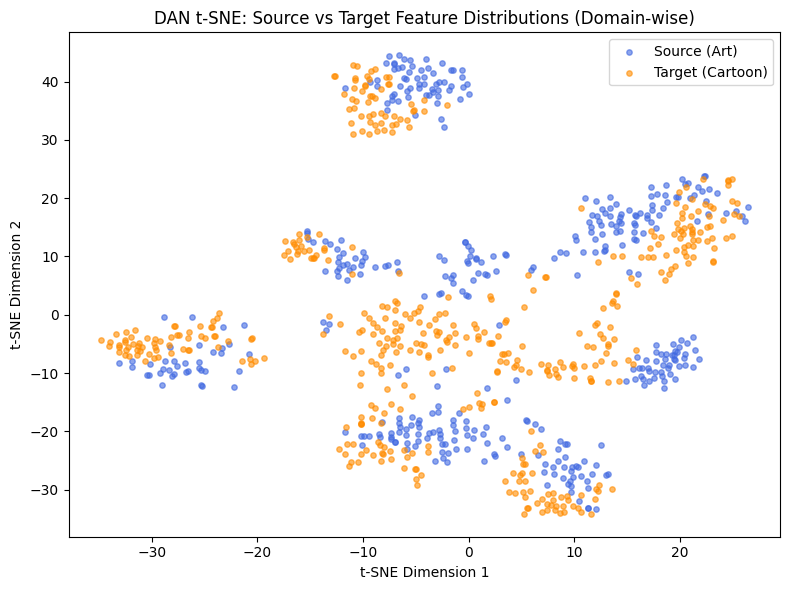

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=500):
    """Extract up to `max_samples` features + domain label (0=source, 1=target)."""
    model.eval()
    feats, domains = [], []
    count = 0

    for x, _ in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        domains.append(torch.full((f.size(0),), domain_label))
        count += f.size(0)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, domains


# --- Extract up to 500 samples per domain ---
src_feats, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

all_feats = torch.cat([src_feats, tgt_feats])
all_domains = torch.cat([src_domains, tgt_domains])


print(f"Running t-SNE on {len(all_feats)} samples:")
feats_np = all_feats.numpy()
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(feats_np)

plt.figure(figsize=(8, 6))
plt.scatter(
    feats_2d[all_domains == 0, 0],
    feats_2d[all_domains == 0, 1],
    c='royalblue', label='Source (Art)', alpha=0.6, s=15
)
plt.scatter(
    feats_2d[all_domains == 1, 0],
    feats_2d[all_domains == 1, 1],
    c='darkorange', label='Target (Cartoon)', alpha=0.6, s=15
)
plt.legend()
plt.title("DAN t-SNE: Source vs Target Feature Distributions (Domain-wise)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()


Running t-SNE on 879 samples:


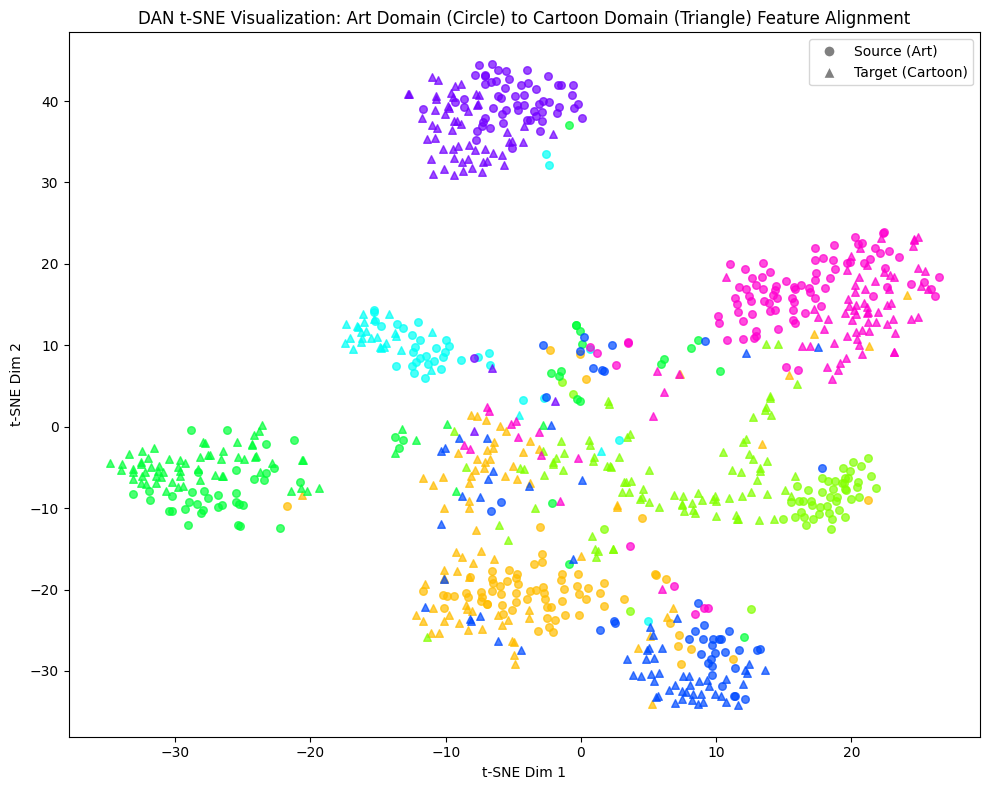

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=250):

    model.eval()
    feats, labels, domains = [], [], []
    count = 0

    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))

        count += len(x)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    labels = torch.cat(labels)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, labels, domains


src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print(f"Running t-SNE on {len(all_feats)} samples:")
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(all_feats.numpy())

labels_np = all_labels.numpy()
domains_np = all_domains.numpy()

num_classes = len(np.unique(labels_np))
palette = sns.color_palette("hsv", num_classes)

plt.figure(figsize=(10, 8))
for cls in range(num_classes):
    idx_src = np.where((labels_np == cls) & (domains_np == 0))[0]
    idx_tgt = np.where((labels_np == cls) & (domains_np == 1))[0]

    plt.scatter(
        feats_2d[idx_src, 0],
        feats_2d[idx_src, 1],
        color=palette[cls],
        marker='o',
        alpha=0.7,
        s=30
    )
    plt.scatter(
        feats_2d[idx_tgt, 0],
        feats_2d[idx_tgt, 1],
        color=palette[cls],
        marker='^',
        alpha=0.7,
        s=30
    )

plt.title("DAN t-SNE Visualization: Art Domain (Circle) to Cartoon Domain (Triangle) Feature Alignment")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Source (Art)', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Target (Cartoon)', markerfacecolor='gray', markersize=8)
]

plt.legend(handles=legend_elems, loc='best', frameon=True)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(classifier.state_dict(), "dan_img_20E.pth")
torch.save(classifier.backbone.state_dict(), "dan_img_20E_backbone.pth")
torch.save(classifier.bottleneck.state_dict(), "dan_img_20E_bottleneck.pth")
torch.save(classifier.head.state_dict(), "dan_img_20E_head.pth")

### DANN (using DALIB)


In [ ]:
!pip install dalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import SGD
import torch.hub
from torchvision import models
from dalib.modules.domain_discriminator import DomainDiscriminator
from dalib.adaptation.dann import DomainAdversarialLoss, ImageClassifier
import numpy as np
np.float = float

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

backbone = ResNet18FeatureExtractor(pretrained=True)

num_classes = 7
classifier = ImageClassifier(backbone, num_classes).to(device)

domain_discriminator = DomainDiscriminator(
    in_feature=classifier.features_dim,
    hidden_size=1024
).to(device)

dann_loss = DomainAdversarialLoss(domain_discriminator).to(device)

optimizer = SGD(
    classifier.get_parameters() + domain_discriminator.get_parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-3,
    nesterov=True
)

def make_infinite(loader):
    """Turn dataloader into infinite generator"""
    while True:
        for data in loader:
            yield data

train_source_iter = make_infinite(art_train_loader)
train_target_iter = make_infinite(cartoon_train_loader)

def train_one_epoch(train_source_iter, train_target_iter, model, dann_loss, optimizer, steps_per_epoch=100):
    model.train()
    dann_loss.train()

    total_loss = 0.0
    for i in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        cls_loss = F.cross_entropy(y_s, labels_s)

        _, f_t = model(x_t)

        transfer_loss = dann_loss(f_s, f_t)

        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / steps_per_epoch

@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total * 100.0

best_acc = 0.0
epochs = 10

for epoch in range(epochs):
    avg_loss = train_one_epoch(train_source_iter, train_target_iter, classifier, dann_loss, optimizer)

    acc = evaluate(cartoon_test_loader, classifier)
    best_acc = max(best_acc, acc)

    print(f"Epoch [{epoch+1}/{epochs}]  |  Loss: {avg_loss:.4f}  |  Target Acc: {acc:.2f}%  |  Best: {best_acc:.2f}%")

print("Training complete.")


Epoch [1/10]  |  Loss: 0.8649  |  Target Acc: 74.63%  |  Best: 74.63%
Epoch [2/10]  |  Loss: 0.5300  |  Target Acc: 73.35%  |  Best: 74.63%
Epoch [3/10]  |  Loss: 0.6392  |  Target Acc: 72.92%  |  Best: 74.63%
Epoch [4/10]  |  Loss: 0.6678  |  Target Acc: 75.27%  |  Best: 75.27%
Epoch [5/10]  |  Loss: 0.6929  |  Target Acc: 74.20%  |  Best: 75.27%
Epoch [6/10]  |  Loss: 0.7000  |  Target Acc: 74.20%  |  Best: 75.27%
Epoch [7/10]  |  Loss: 0.6880  |  Target Acc: 73.99%  |  Best: 75.27%
Epoch [8/10]  |  Loss: 0.7019  |  Target Acc: 77.61%  |  Best: 77.61%
Epoch [9/10]  |  Loss: 0.7200  |  Target Acc: 77.19%  |  Best: 77.61%
Epoch [10/10]  |  Loss: 0.6996  |  Target Acc: 73.77%  |  Best: 77.61%
Training complete.


In [ ]:
print("Accuracy on Art: ", evaluate(art_test_loader, classifier))
print("Accuracy on Cartoon: ", evaluate(cartoon_test_loader, classifier))

Accuracy on Art:  85.60975609756098
Accuracy on Cartoon:  73.77398720682304


#### t-SNE Visualization (Domain-wise)

Running t-SNE...


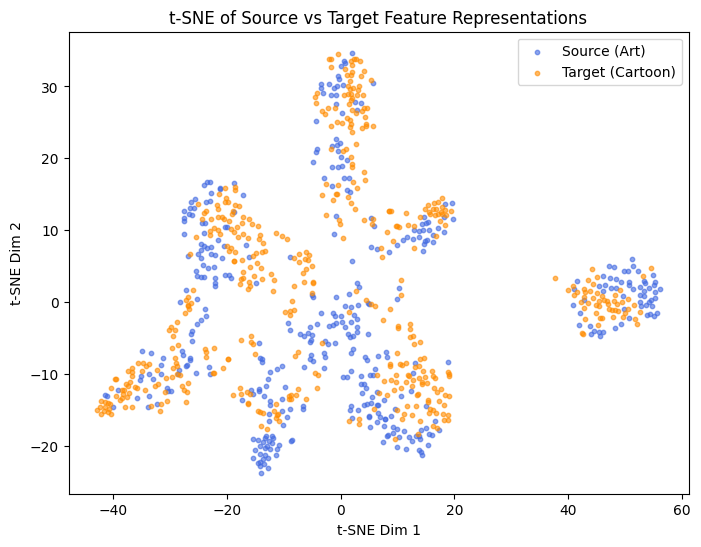

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def extract_features(model, loader, domain_label):
    """Extract features + labels + domain (source=0, target=1)"""
    model.eval()
    feats, labels, domains = [], [], []
    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))
    return torch.cat(feats), torch.cat(labels), torch.cat(domains)

src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print("Running t-SNE:")
tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=30)
feats_2d = tsne.fit_transform(all_feats)

plt.figure(figsize=(8, 6))
plt.scatter(
    feats_2d[all_domains == 0, 0],
    feats_2d[all_domains == 0, 1],
    c='royalblue', label='Source (Art)', alpha=0.6, s=10
)
plt.scatter(
    feats_2d[all_domains == 1, 0],
    feats_2d[all_domains == 1, 1],
    c='darkorange', label='Target (Cartoon)', alpha=0.6, s=10
)
plt.legend()
plt.title("t-SNE of Source vs Target Feature Representations")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


Running t-SNE... (this can take a bit)


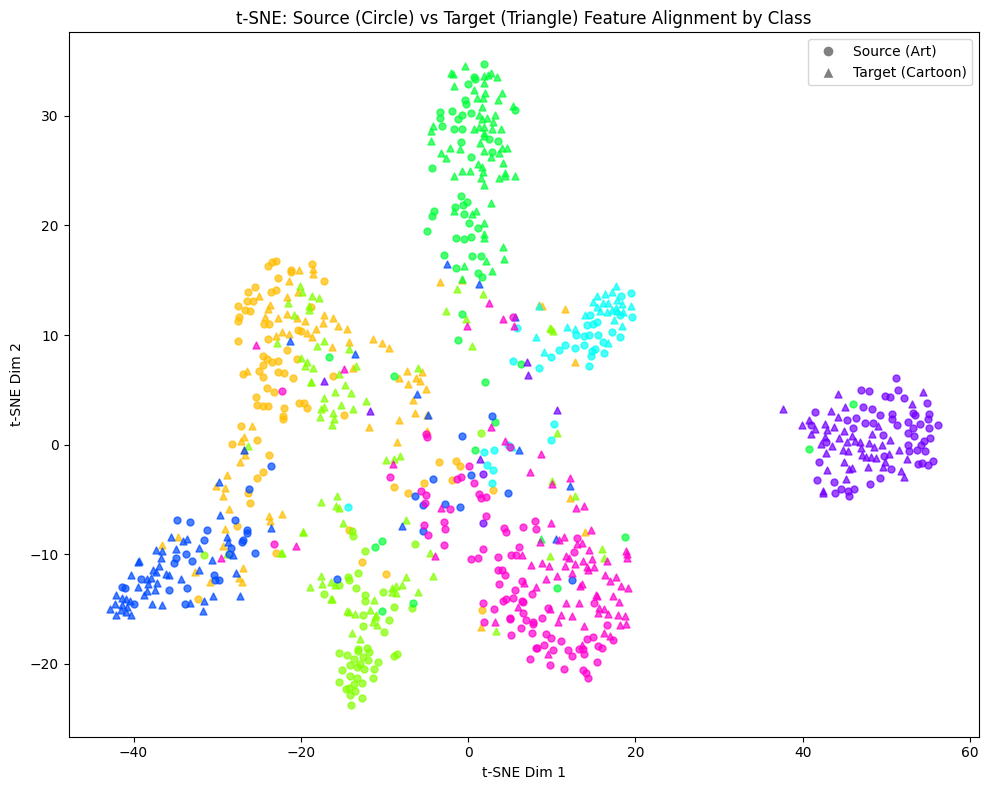

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns

@torch.no_grad()
def extract_features(model, loader, domain_label):
    """Extract features, labels, and domain flags."""
    model.eval()
    feats, labels, domains = [], [], []
    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))
    return torch.cat(feats), torch.cat(labels), torch.cat(domains)

src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print("Running t-SNE:")
tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=30)
feats_2d = tsne.fit_transform(all_feats)

feats_2d = np.array(feats_2d)
labels_np = all_labels.numpy()
domains_np = all_domains.numpy()

num_classes = len(np.unique(labels_np))
palette = sns.color_palette("hsv", num_classes)

plt.figure(figsize=(10, 8))
for cls in range(num_classes):
    idx_src = np.where((labels_np == cls) & (domains_np == 0))[0]
    plt.scatter(
        feats_2d[idx_src, 0],
        feats_2d[idx_src, 1],
        color=palette[cls],
        marker='o',
        alpha=0.7,
        s=25,
        label=f"Class {cls} (Source)" if cls == 0 else None
    )

    idx_tgt = np.where((labels_np == cls) & (domains_np == 1))[0]
    plt.scatter(
        feats_2d[idx_tgt, 0],
        feats_2d[idx_tgt, 1],
        color=palette[cls],
        marker='^',
        alpha=0.7,
        s=25,
        label=f"Class {cls} (Target)" if cls == 0 else None
    )

plt.title("t-SNE: Source (Circle) vs Target (Triangle) Feature Alignment by Class")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

from matplotlib.lines import Line2D

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Source (Art)', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Target (Cartoon)', markerfacecolor='gray', markersize=8)
]
plt.legend(handles=legend_elems, loc='best', frameon=True)

plt.tight_layout()
plt.show()


### DANN v2

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import SGD
import torch.hub
from torchvision import models
from dalib.modules.domain_discriminator import DomainDiscriminator
from dalib.adaptation.dann import DomainAdversarialLoss
from dalib.modules.classifier import Classifier
import numpy as np
np.float = float

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

backbone = ResNet18FeatureExtractor(pretrained=True)

num_classes = 7
classifier = Classifier(backbone, num_classes, bottleneck = None, bottleneck_dim = -1).to(device)

domain_discriminator = DomainDiscriminator(
    in_feature=classifier.features_dim,
    hidden_size=1024
).to(device)

dann_loss = DomainAdversarialLoss(domain_discriminator).to(device)

optimizer = SGD(
    classifier.get_parameters() + domain_discriminator.get_parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=1e-3,
    nesterov=True
)

def make_infinite(loader):
    """Turn dataloader into infinite generator"""
    while True:
        for data in loader:
            yield data

train_source_iter = make_infinite(art_train_loader)
train_target_iter = make_infinite(cartoon_train_loader)

def train_one_epoch(train_source_iter, train_target_iter, model, dann_loss, optimizer, steps_per_epoch=100):
    model.train()
    dann_loss.train()

    total_loss = 0.0
    for i in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        cls_loss = F.cross_entropy(y_s, labels_s)

        _, f_t = model(x_t)

        transfer_loss = dann_loss(f_s, f_t)

        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / steps_per_epoch

@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total * 100.0

best_acc = 0.0
epochs = 20

for epoch in range(epochs):
    avg_loss = train_one_epoch(train_source_iter, train_target_iter, classifier, dann_loss, optimizer)

    acc = evaluate(cartoon_test_loader, classifier)
    src_acc = evaluate(art_test_loader, classifier)
    best_acc = max(best_acc, acc)

    print(f"Epoch [{epoch+1}/{epochs}]  |  Loss: {avg_loss:.4f}  | Source Acc: {src_acc:.2f} | Target Acc: {acc:.2f}%  |  Best: {best_acc:.2f}%")

print("Training complete.")


Epoch [1/20]  |  Loss: 1.4292  | Source Acc: 86.59 | Target Acc: 59.91%  |  Best: 59.91%
Epoch [2/20]  |  Loss: 0.5660  | Source Acc: 87.32 | Target Acc: 65.03%  |  Best: 65.03%
Epoch [3/20]  |  Loss: 0.3283  | Source Acc: 88.54 | Target Acc: 66.52%  |  Best: 66.52%
Epoch [4/20]  |  Loss: 0.2430  | Source Acc: 88.54 | Target Acc: 68.44%  |  Best: 68.44%
Epoch [5/20]  |  Loss: 0.2223  | Source Acc: 87.56 | Target Acc: 70.15%  |  Best: 70.15%
Epoch [6/20]  |  Loss: 0.2248  | Source Acc: 87.56 | Target Acc: 72.49%  |  Best: 72.49%
Epoch [7/20]  |  Loss: 0.2763  | Source Acc: 86.59 | Target Acc: 74.63%  |  Best: 74.63%
Epoch [8/20]  |  Loss: 0.3457  | Source Acc: 86.10 | Target Acc: 74.41%  |  Best: 74.63%
Epoch [9/20]  |  Loss: 0.4590  | Source Acc: 85.61 | Target Acc: 73.77%  |  Best: 74.63%
Epoch [10/20]  |  Loss: 0.5351  | Source Acc: 86.10 | Target Acc: 74.63%  |  Best: 74.63%
Epoch [11/20]  |  Loss: 0.5810  | Source Acc: 86.10 | Target Acc: 76.12%  |  Best: 76.12%
Epoch [12/20]  |  L

Running t-SNE:


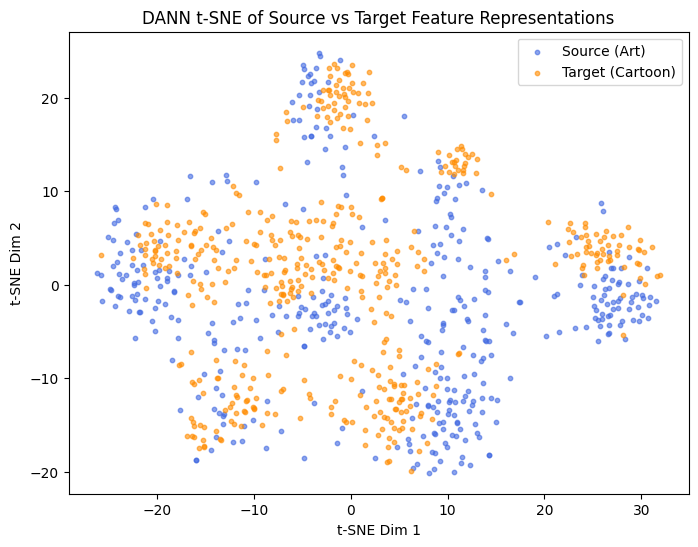

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def extract_features(model, loader, domain_label):
    """Extract features + labels + domain (source=0, target=1)"""
    model.eval()
    feats, labels, domains = [], [], []
    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))
    return torch.cat(feats), torch.cat(labels), torch.cat(domains)

src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print("Running t-SNE:")
tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=30)
feats_2d = tsne.fit_transform(all_feats)

plt.figure(figsize=(8, 6))
plt.scatter(
    feats_2d[all_domains == 0, 0],
    feats_2d[all_domains == 0, 1],
    c='royalblue', label='Source (Art)', alpha=0.6, s=10
)
plt.scatter(
    feats_2d[all_domains == 1, 0],
    feats_2d[all_domains == 1, 1],
    c='darkorange', label='Target (Cartoon)', alpha=0.6, s=10
)
plt.legend()
plt.title("DANN t-SNE of Source vs Target Feature Representations")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


Running t-SNE:


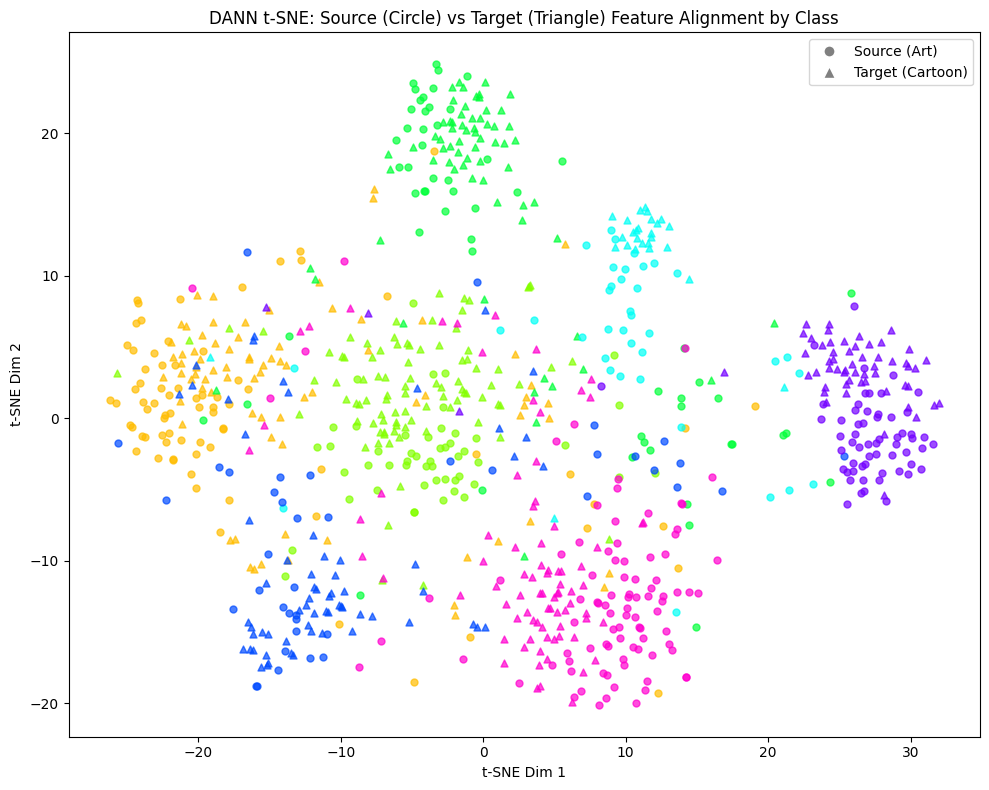

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns

@torch.no_grad()
def extract_features(model, loader, domain_label):
    """Extract features, labels, and domain flags."""
    model.eval()
    feats, labels, domains = [], [], []
    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))
    return torch.cat(feats), torch.cat(labels), torch.cat(domains)

src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print("Running t-SNE:")
tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=30)
feats_2d = tsne.fit_transform(all_feats)

feats_2d = np.array(feats_2d)
labels_np = all_labels.numpy()
domains_np = all_domains.numpy()

num_classes = len(np.unique(labels_np))
palette = sns.color_palette("hsv", num_classes)

plt.figure(figsize=(10, 8))
for cls in range(num_classes):
    idx_src = np.where((labels_np == cls) & (domains_np == 0))[0]
    plt.scatter(
        feats_2d[idx_src, 0],
        feats_2d[idx_src, 1],
        color=palette[cls],
        marker='o',
        alpha=0.7,
        s=25,
        label=f"Class {cls} (Source)" if cls == 0 else None
    )

    idx_tgt = np.where((labels_np == cls) & (domains_np == 1))[0]
    plt.scatter(
        feats_2d[idx_tgt, 0],
        feats_2d[idx_tgt, 1],
        color=palette[cls],
        marker='^',
        alpha=0.7,
        s=25,
        label=f"Class {cls} (Target)" if cls == 0 else None
    )

plt.title("DANN t-SNE: Source (Circle) vs Target (Triangle) Feature Alignment by Class")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

from matplotlib.lines import Line2D

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Source (Art)', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Target (Cartoon)', markerfacecolor='gray', markersize=8)
]
plt.legend(handles=legend_elems, loc='best', frameon=True)

plt.tight_layout()
plt.show()


In [ ]:
torch.save(classifier.state_dict(), "dann_20E.pth")
torch.save(classifier.backbone.state_dict(), "dann_20E_backbone.pth")
torch.save(classifier.head.state_dict(), "dann_20E_head.pth")

### CDAN


In [ ]:
!pip install dalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torchvision import models

from dalib.modules.classifier import Classifier
from dalib.adaptation.cdan import ConditionalDomainAdversarialLoss
from dalib.modules.domain_discriminator import DomainDiscriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
np.float = float

class ResNet18FeatureExtractor(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = torch.nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features  
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

num_classes = 7
backbone = ResNet18FeatureExtractor(pretrained=True)
classifier = Classifier(backbone, num_classes, bottleneck = None, bottleneck_dim=-1).to(device)

print(classifier.features_dim)

domain_discriminator = DomainDiscriminator(
    in_feature=classifier.features_dim * num_classes,
    hidden_size=512
).to(device)

cdan_loss = ConditionalDomainAdversarialLoss(domain_discriminator, entropy_conditioning=True).to(device)

alpha = 10.0
beta = 0.75
grl_gamma = 10.0
momentum = 0.9
weight_decay = 5e-4
epochs = 10
steps_per_epoch = 100

params = [
    {"params": [p for n, p in classifier.backbone.named_parameters() if p.requires_grad], "lr": 0.001},
    {"params": classifier.head.parameters(), "lr": 0.01},
    {"params": domain_discriminator.parameters(), "lr": 0.001},  # discriminator same as classifier
]

optimizer = torch.optim.SGD(params, momentum=0.9, weight_decay=5e-4, nesterov=True)


def make_infinite(loader):
    while True:
        for batch in loader:
            yield batch

train_source_iter = make_infinite(art_train_loader)
train_target_iter = make_infinite(cartoon_train_loader)


def inv_lr_scheduler(optimizer, iter_num, gamma=0.001, power=0.75, lr=0.001, weight_decay=0.0005):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = lr * (1 + gamma * iter_num) ** (-power)
    i=0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * param_group['lr_mult']
        param_group['weight_decay'] = weight_decay * param_group['decay_mult']
        i+=1

    return optimizer


schedule_dict = {"inv":inv_lr_scheduler}


def train_one_epoch_cdan(train_source_iter, train_target_iter,
                         model, cdan_loss, optimizer,
                         epoch, total_epochs, steps_per_epoch=100):
    model.train()
    if hasattr(cdan_loss, 'train'):
        cdan_loss.train()

    total_loss = 0.0

    for step in range(steps_per_epoch):
        
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        y_t, f_t = model(x_t)

        cls_loss = F.cross_entropy(y_s, labels_s)
        transfer_loss = cdan_loss(y_s, f_s, y_t, f_t)


        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 20 == 0:
           print(f"step {step} | cls_loss={cls_loss.item():.4f} | transfer_loss={transfer_loss.item():.4f}")

    return total_loss / steps_per_epoch


@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total * 100.0


best_acc = 0.0
for epoch in range(epochs):
    avg_loss = train_one_epoch_cdan(train_source_iter, train_target_iter, classifier, cdan_loss, optimizer,
                                    epoch, epochs, steps_per_epoch=steps_per_epoch)

    src_acc = evaluate(art_test_loader, classifier)
    acc = evaluate(cartoon_test_loader, classifier)
    best_acc = max(best_acc, acc)
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Source Acc {src_acc:.2f} | Target Acc: {acc:.2f}% | Best: {best_acc:.2f}%")


512
step 0 | cls_loss=1.9982 | transfer_loss=0.7169
step 20 | cls_loss=0.7351 | transfer_loss=0.6854
step 40 | cls_loss=0.1649 | transfer_loss=0.4935
step 60 | cls_loss=0.0799 | transfer_loss=0.4690
step 80 | cls_loss=0.0374 | transfer_loss=0.2953
Epoch [1/10] | Loss: 0.9185 | Source Acc 86.59 | Target Acc: 63.54% | Best: 63.54%
step 0 | cls_loss=0.0356 | transfer_loss=0.2842
step 20 | cls_loss=0.0251 | transfer_loss=0.2829
step 40 | cls_loss=0.0227 | transfer_loss=0.2597
step 60 | cls_loss=0.0408 | transfer_loss=0.2887
step 80 | cls_loss=0.0087 | transfer_loss=0.1773
Epoch [2/10] | Loss: 0.2701 | Source Acc 87.56 | Target Acc: 64.82% | Best: 64.82%
step 0 | cls_loss=0.0112 | transfer_loss=0.1680
step 20 | cls_loss=0.0108 | transfer_loss=0.2184
step 40 | cls_loss=0.0276 | transfer_loss=0.0744
step 60 | cls_loss=0.0055 | transfer_loss=0.0879
step 80 | cls_loss=0.0042 | transfer_loss=0.1009
Epoch [3/10] | Loss: 0.1487 | Source Acc 88.05 | Target Acc: 63.75% | Best: 64.82%
step 0 | cls_lo

Running t-SNE on 879 samples:


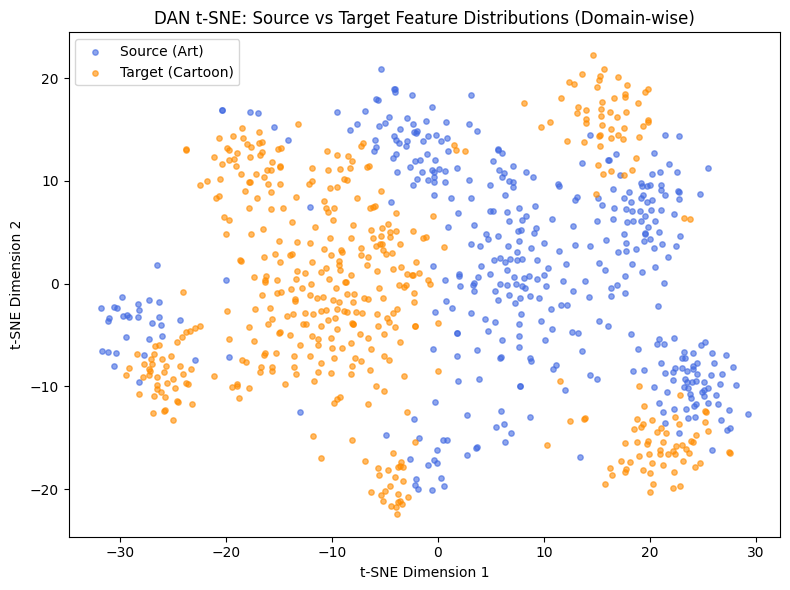

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=500):
    """Extract up to `max_samples` features + domain label (0=source, 1=target)."""
    model.eval()
    feats, domains = [], []
    count = 0

    for x, _ in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        domains.append(torch.full((f.size(0),), domain_label))
        count += f.size(0)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, domains


src_feats, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

all_feats = torch.cat([src_feats, tgt_feats])
all_domains = torch.cat([src_domains, tgt_domains])

print(f"Running t-SNE on {len(all_feats)} samples:")
feats_np = all_feats.numpy()
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(feats_np)

plt.figure(figsize=(8, 6))
plt.scatter(
    feats_2d[all_domains == 0, 0],
    feats_2d[all_domains == 0, 1],
    c='royalblue', label='Source (Art)', alpha=0.6, s=15
)
plt.scatter(
    feats_2d[all_domains == 1, 0],
    feats_2d[all_domains == 1, 1],
    c='darkorange', label='Target (Cartoon)', alpha=0.6, s=15
)
plt.legend()
plt.title("DAN t-SNE: Source vs Target Feature Distributions (Domain-wise)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()


Running t-SNE on 879 samples:


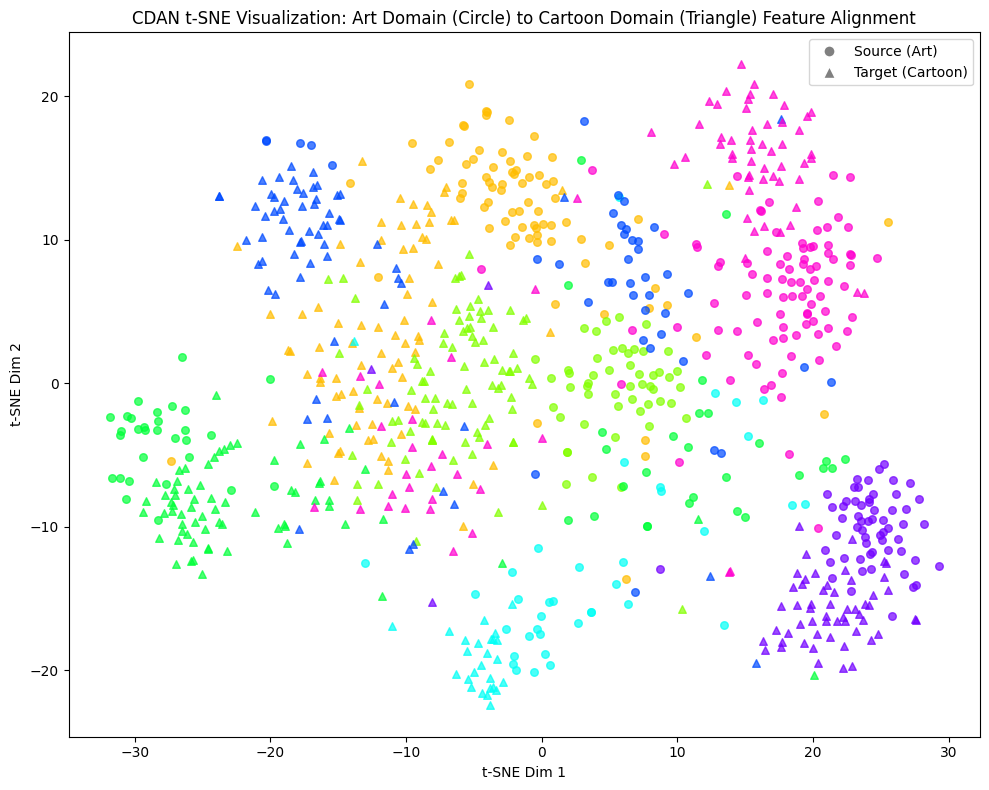

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=250):

    model.eval()
    feats, labels, domains = [], [], []
    count = 0

    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))

        count += len(x)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    labels = torch.cat(labels)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, labels, domains


src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print(f"Running t-SNE on {len(all_feats)} samples:")
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(all_feats.numpy())

labels_np = all_labels.numpy()
domains_np = all_domains.numpy()

num_classes = len(np.unique(labels_np))
palette = sns.color_palette("hsv", num_classes)

plt.figure(figsize=(10, 8))
for cls in range(num_classes):
    idx_src = np.where((labels_np == cls) & (domains_np == 0))[0]
    idx_tgt = np.where((labels_np == cls) & (domains_np == 1))[0]

    plt.scatter(
        feats_2d[idx_src, 0],
        feats_2d[idx_src, 1],
        color=palette[cls],
        marker='o',
        alpha=0.7,
        s=30
    )
    plt.scatter(
        feats_2d[idx_tgt, 0],
        feats_2d[idx_tgt, 1],
        color=palette[cls],
        marker='^',
        alpha=0.7,
        s=30
    )

plt.title("CDAN t-SNE Visualization: Art Domain (Circle) to Cartoon Domain (Triangle) Feature Alignment")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Source (Art)', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Target (Cartoon)', markerfacecolor='gray', markersize=8)
]

plt.legend(handles=legend_elems, loc='best', frameon=True)
plt.tight_layout()
plt.show()


### CDAN v2

In [ ]:
!pip install dalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torchvision import models

from dalib.modules.classifier import Classifier
from dalib.adaptation.cdan import ConditionalDomainAdversarialLoss
from dalib.modules.domain_discriminator import DomainDiscriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
np.float = float

class ResNet18FeatureExtractor(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = torch.nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features      def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

num_classes = 7
backbone = ResNet18FeatureExtractor(pretrained=True)
classifier = Classifier(backbone, num_classes, bottleneck = None, bottleneck_dim=-1).to(device)

domain_discriminator = DomainDiscriminator(
    in_feature=classifier.features_dim * num_classes,
    hidden_size=512
).to(device)

cdan_loss = ConditionalDomainAdversarialLoss(domain_discriminator, entropy_conditioning=True).to(device)

alpha = 10.0
beta = 0.75
grl_gamma = 10.0
momentum = 0.9
weight_decay = 5e-4
epochs = 10
steps_per_epoch = 100

params = [
    {"params": [p for n, p in classifier.backbone.named_parameters() if p.requires_grad], "lr": 0.001},
    {"params": classifier.head.parameters(), "lr": 0.001},
    {"params": domain_discriminator.parameters(), "lr": 0.0001},
]

optimizer = torch.optim.SGD(params, momentum=0.9, weight_decay=5e-4, nesterov=True)


def make_infinite(loader):
    while True:
        for batch in loader:
            yield batch

train_source_iter = make_infinite(art_train_loader)
train_target_iter = make_infinite(cartoon_train_loader)


def inv_lr_scheduler(optimizer, iter_num, gamma=0.001, power=0.75, lr=0.001, weight_decay=0.0005):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = lr * (1 + gamma * iter_num) ** (-power)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer


schedule_dict = {"inv":inv_lr_scheduler}


def train_one_epoch_cdan(train_source_iter, train_target_iter,
                         model, cdan_loss, optimizer,
                         epoch, total_epochs, steps_per_epoch=100):
    model.train()
    if hasattr(cdan_loss, 'train'):
        cdan_loss.train()

    total_loss = 0.0

    for step in range(steps_per_epoch):

        optimizer = inv_lr_scheduler(optimizer, step)

        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        y_t, f_t = model(x_t)

        cls_loss = F.cross_entropy(y_s, labels_s)
        transfer_loss = cdan_loss(y_s, f_s, y_t, f_t)


        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 20 == 0:
           print(f"step {step} | cls_loss={cls_loss.item():.4f} | transfer_loss={transfer_loss.item():.4f}")

    return total_loss / steps_per_epoch


@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total * 100.0


best_acc = 0.0
for epoch in range(20):
    avg_loss = train_one_epoch_cdan(train_source_iter, train_target_iter, classifier, cdan_loss, optimizer,
                                    epoch, epochs, steps_per_epoch=steps_per_epoch)

    src_acc = evaluate(art_test_loader, classifier)
    acc = evaluate(cartoon_test_loader, classifier)
    best_acc = max(best_acc, acc)
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Source Acc {src_acc:.2f} | Target Acc: {acc:.2f}% | Best: {best_acc:.2f}%")


step 0 | cls_loss=2.3520 | transfer_loss=0.6960
step 20 | cls_loss=1.4596 | transfer_loss=0.6855
step 40 | cls_loss=0.8749 | transfer_loss=0.6134
step 60 | cls_loss=0.2693 | transfer_loss=0.4491
step 80 | cls_loss=0.3271 | transfer_loss=0.3846
Epoch [1/10] | Loss: 1.3627 | Source Acc 88.05 | Target Acc: 60.55% | Best: 60.55%
step 0 | cls_loss=0.3924 | transfer_loss=0.3677
step 20 | cls_loss=0.2593 | transfer_loss=0.2703
step 40 | cls_loss=0.0711 | transfer_loss=0.2622
step 60 | cls_loss=0.1479 | transfer_loss=0.1938
step 80 | cls_loss=0.1113 | transfer_loss=0.1837
Epoch [2/10] | Loss: 0.3909 | Source Acc 88.78 | Target Acc: 63.97% | Best: 63.97%
step 0 | cls_loss=0.2576 | transfer_loss=0.1536
step 20 | cls_loss=0.0444 | transfer_loss=0.1581
step 40 | cls_loss=0.0808 | transfer_loss=0.1471
step 60 | cls_loss=0.0691 | transfer_loss=0.1047
step 80 | cls_loss=0.0524 | transfer_loss=0.1621
Epoch [3/10] | Loss: 0.1937 | Source Acc 89.51 | Target Acc: 66.10% | Best: 66.10%
step 0 | cls_loss=0

Running t-SNE on 879 samples:


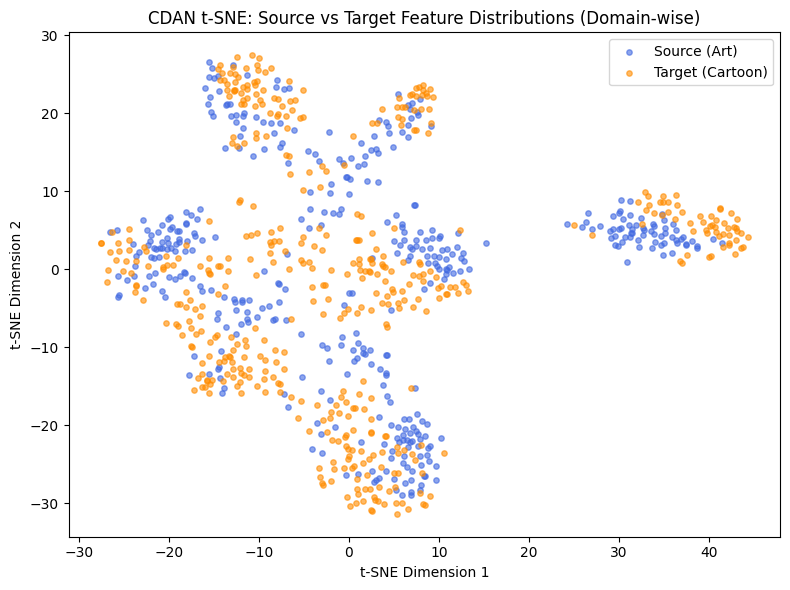

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=500):
    """Extract up to `max_samples` features + domain label (0=source, 1=target)."""
    model.eval()
    feats, domains = [], []
    count = 0

    for x, _ in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        domains.append(torch.full((f.size(0),), domain_label))
        count += f.size(0)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, domains


src_feats, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

all_feats = torch.cat([src_feats, tgt_feats])
all_domains = torch.cat([src_domains, tgt_domains])

print(f"Running t-SNE on {len(all_feats)} samples:")
feats_np = all_feats.numpy()
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(feats_np)

plt.figure(figsize=(8, 6))
plt.scatter(
    feats_2d[all_domains == 0, 0],
    feats_2d[all_domains == 0, 1],
    c='royalblue', label='Source (Art)', alpha=0.6, s=15
)
plt.scatter(
    feats_2d[all_domains == 1, 0],
    feats_2d[all_domains == 1, 1],
    c='darkorange', label='Target (Cartoon)', alpha=0.6, s=15
)
plt.legend()
plt.title("CDAN t-SNE: Source vs Target Feature Distributions (Domain-wise)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()


Running t-SNE on 879 samples:


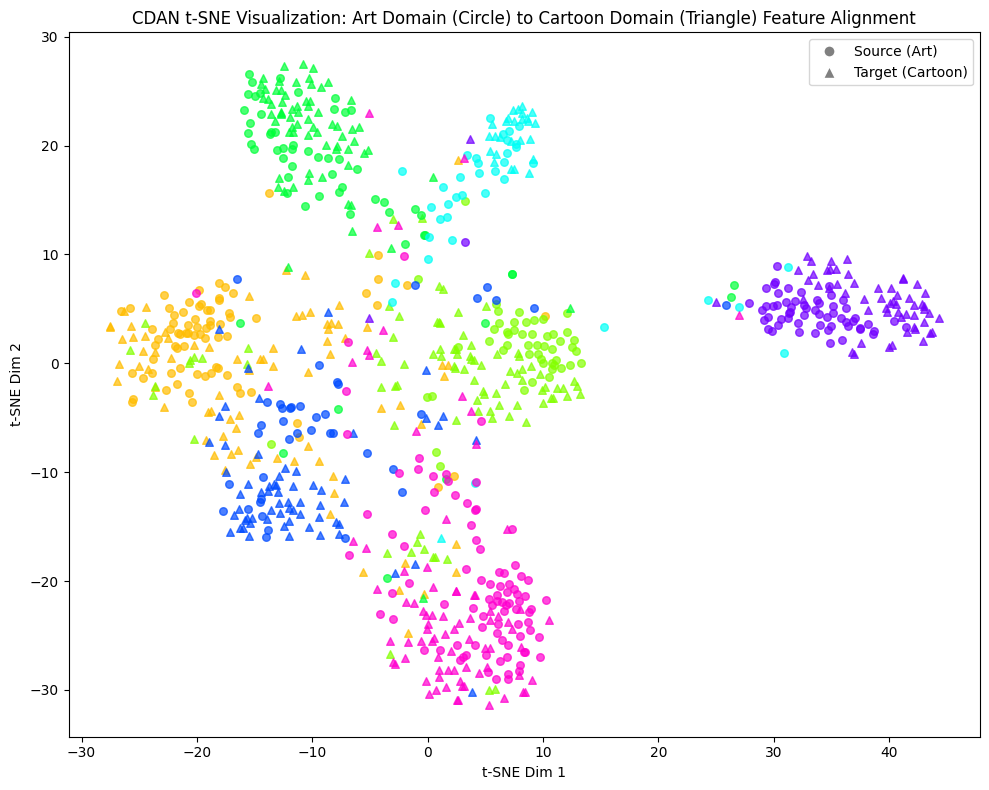

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=250):

    model.eval()
    feats, labels, domains = [], [], []
    count = 0

    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))

        count += len(x)
        if count >= max_samples:
            break

    feats = torch.cat(feats)[:max_samples]
    labels = torch.cat(labels)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, labels, domains


src_feats, src_labels, src_domains = extract_features(classifier, art_test_loader, domain_label=0, max_samples=500)
tgt_feats, tgt_labels, tgt_domains = extract_features(classifier, cartoon_test_loader, domain_label=1, max_samples=500)

all_feats = torch.cat([src_feats, tgt_feats])
all_labels = torch.cat([src_labels, tgt_labels])
all_domains = torch.cat([src_domains, tgt_domains])

print(f"Running t-SNE on {len(all_feats)} samples:")
tsne = TSNE(n_components=2, random_state=42)
feats_2d = tsne.fit_transform(all_feats.numpy())

labels_np = all_labels.numpy()
domains_np = all_domains.numpy()

num_classes = len(np.unique(labels_np))
palette = sns.color_palette("hsv", num_classes)

plt.figure(figsize=(10, 8))
for cls in range(num_classes):
    idx_src = np.where((labels_np == cls) & (domains_np == 0))[0]
    idx_tgt = np.where((labels_np == cls) & (domains_np == 1))[0]

    plt.scatter(
        feats_2d[idx_src, 0],
        feats_2d[idx_src, 1],
        color=palette[cls],
        marker='o',
        alpha=0.7,
        s=30
    )
    plt.scatter(
        feats_2d[idx_tgt, 0],
        feats_2d[idx_tgt, 1],
        color=palette[cls],
        marker='^',
        alpha=0.7,
        s=30
    )

plt.title("CDAN t-SNE Visualization: Art Domain (Circle) to Cartoon Domain (Triangle) Feature Alignment")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Source (Art)', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Target (Cartoon)', markerfacecolor='gray', markersize=8)
]

plt.legend(handles=legend_elems, loc='best', frameon=True)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(classifier.state_dict(), "cdan_20E.pth")
torch.save(classifier.backbone.state_dict(), "cdan_20E_backbone.pth")
torch.save(classifier.head.state_dict(), "cdan_20E_head.pth")

## T-SNE Evaluation and Silhouette Scores

In [ ]:
!pip install dalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import torch
from dalib.modules.classifier import Classifier
from dalib.adaptation.dan import ImageClassifier
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

num_classes = 7

def load_classifier(model_name, has_bottleneck=False):
    backbone = ResNet18FeatureExtractor(pretrained=True)

    if has_bottleneck:
        classifier = Classifier(backbone, num_classes, bottleneck_dim=256)
    else:
        classifier = Classifier(backbone, num_classes, bottleneck_dim=None)

    classifier.to(device)

    classifier.backbone.load_state_dict(torch.load(f"{model_name}_backbone.pth", map_location=device))
    classifier.head.load_state_dict(torch.load(f"{model_name}_head.pth", map_location=device))
    if has_bottleneck:
        classifier.bottleneck.load_state_dict(torch.load(f"{model_name}_bottleneck.pth", map_location=device))

    return classifier

def load_dan_model(backbone_path, head_path, num_classes=7):
    """
    Loads a DAN ImageClassifier from saved weights.
    backbone_path: path to saved backbone state_dict
    head_path: path to saved head state_dict
    """
    backbone = ResNet18FeatureExtractor(pretrained=True)
    model = ImageClassifier(backbone, num_classes=num_classes)
    model.to(device)

    
    return model

@torch.no_grad()
def extract_features(model, loader, domain_label, max_samples=500):
    model.eval()
    feats, labels, domains = [], [], []
    count = 0
    for x, y in loader:
        x = x.to(device)
        _, f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))
        count += len(x)
        if count >= max_samples:
            break
    feats = torch.cat(feats)[:max_samples]
    labels = torch.cat(labels)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, labels, domains

@torch.no_grad()
def extract_features_baseline(model, loader, domain_label, max_samples=500):
    model.eval()
    feats, labels, domains = [], [], []
    count = 0
    for x, y in loader:
        x = x.to(device)
        f = model(x)
        feats.append(f.cpu())
        labels.append(y)
        domains.append(torch.full_like(y, domain_label))
        count += len(x)
        if count >= max_samples:
            break
    feats = torch.cat(feats)[:max_samples]
    labels = torch.cat(labels)[:max_samples]
    domains = torch.cat(domains)[:max_samples]
    return feats, labels, domains

In [ ]:
dan_model = load_dan_model("dan_img_20E_backbone.pth", "dan_img_20E_head.pth")
dann_model = load_classifier("dann_20E", has_bottleneck=False)
cdan_model = load_classifier("cdan_20E", has_bottleneck=False)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np

def get_tsne_silhouette(model, source_loader, target_loader):
    src_feats, src_labels, src_domains = extract_features(model, source_loader, 0)
    tgt_feats, tgt_labels, tgt_domains = extract_features(model, target_loader, 1)

    all_feats = torch.cat([src_feats, tgt_feats]).numpy()
    all_labels = torch.cat([src_labels, tgt_labels]).numpy()

    tsne = TSNE(n_components=2, random_state=42)
    feats_2d = tsne.fit_transform(all_feats)

    sil_score = silhouette_score(feats_2d, all_labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    return feats_2d, all_labels, sil_score

def get_tsne_silhouette_baseline(model, source_loader, target_loader):
    src_feats, src_labels, src_domains = extract_features_baseline(model, source_loader, 0)
    tgt_feats, tgt_labels, tgt_domains = extract_features_baseline(model, target_loader, 1)

    all_feats = torch.cat([src_feats, tgt_feats]).numpy()
    all_labels = torch.cat([src_labels, tgt_labels]).numpy()

    tsne = TSNE(n_components=2, random_state=42)
    feats_2d = tsne.fit_transform(all_feats)

    sil_score = silhouette_score(feats_2d, all_labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    return feats_2d, all_labels, sil_score

In [ ]:
baseline_feats, baseline_labels, bs_sil = get_tsne_silhouette_baseline(extractor, art_test_loader, cartoon_test_loader)
print("Baseline SIL:", bs_sil)

Silhouette Score: 0.1612
Baseline SIL: 0.16124107


In [ ]:
dan_feats, dan_labels, dan_sil = get_tsne_silhouette(dan_model, art_test_loader, cartoon_test_loader)
dann_feats, dann_labels, dann_sil = get_tsne_silhouette(dann_model, art_test_loader, cartoon_test_loader)
cdan_feats, cdan_labels, cdan_sil = get_tsne_silhouette(cdan_model, art_test_loader, cartoon_test_loader)

print("DAN SIL:", dan_sil)
print("DANN SIL:", dann_sil)
print("CDAN SIL", cdan_sil)

Silhouette Score: 0.3080
Silhouette Score: 0.2626
Silhouette Score: 0.3441
DAN SIL: 0.3080151
DANN SIL: 0.2625609
CDAN SIL 0.34409994


## Task 1.3: Pseudo-labeling (following model from Task 1.1)

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_pseudo_labels(model, target_loader, threshold=0.8):
    model.eval()
    pseudo_images, pseudo_labels = [], []

    with torch.no_grad():
        for images, _ in target_loader:
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            max_probs, preds = probs.max(dim=1)

            mask = max_probs >= threshold
            pseudo_images.append(images[mask].cpu())
            pseudo_labels.append(preds[mask].cpu())

    if len(pseudo_images) == 0:
        print("No pseudo-labeled samples met the confidence threshold.")
        return None, None

    pseudo_images = torch.cat(pseudo_images)
    pseudo_labels = torch.cat(pseudo_labels)
    print(f"✅ Collected {len(pseudo_labels)} pseudo-labeled target samples.")
    return pseudo_images, pseudo_labels


def fine_tune_on_pseudo(model, pseudo_images, pseudo_labels, epochs=10, batch_size=32, lr=1e-4):
    dataset = torch.utils.data.TensorDataset(pseudo_images, pseudo_labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Fine-tune Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(loader):.4f}")
    return model


@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total * 100


In [ ]:
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_classes = len(art_dataset.classes)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

### Old

In [ ]:
pseudo_images, pseudo_labels = generate_pseudo_labels(model, cartoon_train_loader, threshold=0.9)

if pseudo_images is not None:
    model = fine_tune_on_pseudo(model, pseudo_images, pseudo_labels, epochs=10, lr=1e-4)

final_acc = evaluate(cartoon_test_loader, model)
src_acc = evaluate(art_test_loader, model)
print(f"🎯 Target (Cartoon) Accuracy after Self-Training: {final_acc:.2f}%")


✅ Collected 763 pseudo-labeled target samples.
Fine-tune Epoch [1/5] | Loss: 0.0784
Fine-tune Epoch [2/5] | Loss: 0.0443
Fine-tune Epoch [3/5] | Loss: 0.0181
Fine-tune Epoch [4/5] | Loss: 0.0112
Fine-tune Epoch [5/5] | Loss: 0.0099
🎯 Target (Cartoon) Accuracy after Self-Training: 58.85%


### New

In [ ]:
sd = torch.load("resnet18_source_only_baseline.pth")
model.load_state_dict(sd)
pseudo_images, pseudo_labels = generate_pseudo_labels(model, cartoon_train_loader, threshold=0.9)

if pseudo_images is not None:
    model = fine_tune_on_pseudo(model, pseudo_images, pseudo_labels, epochs=20, lr=2e-5)

final_acc = evaluate(cartoon_test_loader, model)
src_acc = evaluate(art_test_loader, model)
print(f"Source (Art) Accuracy after Self-Training: {src_acc:.2f}%")
print(f"Target (Cartoon) Accuracy after Self-Training: {final_acc:.2f}%")

✅ Collected 1020 pseudo-labeled target samples.
Fine-tune Epoch [1/20] | Loss: 0.3671
Fine-tune Epoch [2/20] | Loss: 0.0590
Fine-tune Epoch [3/20] | Loss: 0.0237
Fine-tune Epoch [4/20] | Loss: 0.0220
Fine-tune Epoch [5/20] | Loss: 0.0125
Fine-tune Epoch [6/20] | Loss: 0.0175
Fine-tune Epoch [7/20] | Loss: 0.0084
Fine-tune Epoch [8/20] | Loss: 0.0101
Fine-tune Epoch [9/20] | Loss: 0.0045
Fine-tune Epoch [10/20] | Loss: 0.0048
Fine-tune Epoch [11/20] | Loss: 0.0035
Fine-tune Epoch [12/20] | Loss: 0.0024
Fine-tune Epoch [13/20] | Loss: 0.0021
Fine-tune Epoch [14/20] | Loss: 0.0032
Fine-tune Epoch [15/20] | Loss: 0.0044
Fine-tune Epoch [16/20] | Loss: 0.0032
Fine-tune Epoch [17/20] | Loss: 0.0029
Fine-tune Epoch [18/20] | Loss: 0.0023
Fine-tune Epoch [19/20] | Loss: 0.0039
Fine-tune Epoch [20/20] | Loss: 0.0043
Source (Art) Accuracy after Self-Training: 85.37%
Target (Cartoon) Accuracy after Self-Training: 58.85%


In [ ]:
sd = torch.load("resnet18_source_only_baseline.pth")
model.load_state_dict(sd)
pseudo_images, pseudo_labels = generate_pseudo_labels(model, cartoon_train_loader, threshold=0.95)

if pseudo_images is not None:
    model = fine_tune_on_pseudo(model, pseudo_images, pseudo_labels, epochs=20, lr=2e-5)

final_acc = evaluate(cartoon_test_loader, model)
src_acc = evaluate(art_test_loader, model)
print(f"Source (Art) Accuracy after Self-Training: {src_acc:.2f}%")
print(f"Target (Cartoon) Accuracy after Self-Training: {final_acc:.2f}%")

✅ Collected 837 pseudo-labeled target samples.
Fine-tune Epoch [1/20] | Loss: 0.3216
Fine-tune Epoch [2/20] | Loss: 0.0535
Fine-tune Epoch [3/20] | Loss: 0.0355
Fine-tune Epoch [4/20] | Loss: 0.0127
Fine-tune Epoch [5/20] | Loss: 0.0369
Fine-tune Epoch [6/20] | Loss: 0.0089
Fine-tune Epoch [7/20] | Loss: 0.0116
Fine-tune Epoch [8/20] | Loss: 0.0085
Fine-tune Epoch [9/20] | Loss: 0.0093
Fine-tune Epoch [10/20] | Loss: 0.0277
Fine-tune Epoch [11/20] | Loss: 0.0497
Fine-tune Epoch [12/20] | Loss: 0.0036
Fine-tune Epoch [13/20] | Loss: 0.0403
Fine-tune Epoch [14/20] | Loss: 0.0098
Fine-tune Epoch [15/20] | Loss: 0.0159
Fine-tune Epoch [16/20] | Loss: 0.0191
Fine-tune Epoch [17/20] | Loss: 0.0136
Fine-tune Epoch [18/20] | Loss: 0.0442
Fine-tune Epoch [19/20] | Loss: 0.0077
Fine-tune Epoch [20/20] | Loss: 0.0049
Source (Art) Accuracy after Self-Training: 84.39%
Target (Cartoon) Accuracy after Self-Training: 60.77%


In [ ]:
sd = torch.load("resnet18_source_only_baseline.pth")
model.load_state_dict(sd)
pseudo_images, pseudo_labels = generate_pseudo_labels(model, cartoon_train_loader, threshold=0.95)

if pseudo_images is not None:
    model = fine_tune_on_pseudo(model, pseudo_images, pseudo_labels, epochs=10, lr=2e-5)
7
final_acc = evaluate(cartoon_test_loader, model)
src_acc = evaluate(art_test_loader, model)
print(f"Source (Art) Accuracy after Self-Training: {src_acc:.2f}%")
print(f"Target (Cartoon) Accuracy after Self-Training: {final_acc:.2f}%")

✅ Collected 835 pseudo-labeled target samples.
Fine-tune Epoch [1/10] | Loss: 0.3204
Fine-tune Epoch [2/10] | Loss: 0.0398
Fine-tune Epoch [3/10] | Loss: 0.0608
Fine-tune Epoch [4/10] | Loss: 0.0172
Fine-tune Epoch [5/10] | Loss: 0.0233
Fine-tune Epoch [6/10] | Loss: 0.0139
Fine-tune Epoch [7/10] | Loss: 0.0107
Fine-tune Epoch [8/10] | Loss: 0.0075
Fine-tune Epoch [9/10] | Loss: 0.0094
Fine-tune Epoch [10/10] | Loss: 0.0746
Source (Art) Accuracy after Self-Training: 84.88%
Target (Cartoon) Accuracy after Self-Training: 58.42%


## Task 1.4: Concept Shift

In [ ]:
!pip install dalib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torchvision import models
from torch.utils.data import DataLoader, Subset
from collections import Counter

from dalib.modules.classifier import Classifier
from dalib.adaptation.cdan import ConditionalDomainAdversarialLoss
from dalib.adaptation.dann import DomainAdversarialLoss
from dalib.adaptation.dan import MultipleKernelMaximumMeanDiscrepancy
from dalib.modules.domain_discriminator import DomainDiscriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.float = float

# ============================================================================
# MODEL DEFINITION
# ============================================================================

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        else:
            base_model = models.resnet18(weights=None)

        self.features = nn.Sequential(*list(base_model.children())[:-1])
        self.out_features = base_model.fc.in_features

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x


# ============================================================================
# IMPROVED DATA MANIPULATION FUNCTIONS
# ============================================================================

def create_severe_label_shift(dataset, remove_classes, oversample_classes, random_state=42):
    """
    Create SEVERE label shift by completely removing some classes and oversampling others.
    This creates P_s(Y) and P_t(Y) with non-overlapping support.

    Args:
        dataset: The original dataset
        remove_classes: List of class IDs to completely remove from target
        oversample_classes: Dict mapping class_id -> oversample factor
    """
    np.random.seed(random_state)

    if isinstance(dataset, Subset):
        labels = np.array([dataset.dataset.samples[i][1] for i in dataset.indices])
        indices = np.array(dataset.indices)
    else:
        labels = np.array([s[1] for s in dataset.samples])
        indices = np.arange(len(labels))

    # Remove specified classes completely
    keep_mask = np.ones(len(labels), dtype=bool)
    for cls in remove_classes:
        keep_mask &= (labels != cls)

    filtered_indices = indices[keep_mask]
    filtered_labels = labels[keep_mask]

    # Oversample specified classes
    new_indices = list(filtered_indices)
    for cls, factor in oversample_classes.items():
        cls_mask = filtered_labels == cls
        cls_indices = filtered_indices[cls_mask]
        # Add (factor-1) copies
        for _ in range(factor - 1):
            new_indices.extend(cls_indices)

    np.random.shuffle(new_indices)

    if isinstance(dataset, Subset):
        return Subset(dataset.dataset, new_indices)
    else:
        return Subset(dataset, new_indices)


def create_semantic_shift(dataset, confuse_pairs, confusion_rate=0.3, random_state=42):
    """
    Create semantic/concept shift by swapping labels between similar classes.
    This simulates when categories have different meanings across domains.

    Args:
        dataset: The original dataset
        confuse_pairs: List of (class_a, class_b) tuples to swap
        confusion_rate: Proportion of samples to swap labels
    """
    np.random.seed(random_state)

    if isinstance(dataset, Subset):
        base_dataset = dataset.dataset
        indices = np.array(dataset.indices)
        labels = np.array([base_dataset.samples[i][1] for i in indices])
    else:
        base_dataset = dataset
        indices = np.arange(len(dataset))
        labels = np.array([s[1] for s in dataset.samples])

    # Create modified samples list
    modified_samples = [base_dataset.samples[i] for i in indices]

    for class_a, class_b in confuse_pairs:
        # Find samples of both classes
        mask_a = labels == class_a
        mask_b = labels == class_b

        # Randomly select samples to swap
        swap_a_indices = np.where(mask_a)[0]
        swap_b_indices = np.where(mask_b)[0]

        n_swap_a = int(len(swap_a_indices) * confusion_rate)
        n_swap_b = int(len(swap_b_indices) * confusion_rate)

        swap_a_selected = np.random.choice(swap_a_indices, n_swap_a, replace=False)
        swap_b_selected = np.random.choice(swap_b_indices, n_swap_b, replace=False)

        # Swap labels
        for idx in swap_a_selected:
            path, _ = modified_samples[idx]
            modified_samples[idx] = (path, class_b)

        for idx in swap_b_selected:
            path, _ = modified_samples[idx]
            modified_samples[idx] = (path, class_a)

    # Create new dataset with modified labels
    class ModifiedDataset:
        def __init__(self, samples, transform):
            self.samples = samples
            self.transform = transform
            self.loader = base_dataset.loader

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            path, label = self.samples[idx]
            img = self.loader(path)
            if self.transform:
                img = self.transform(img)
            return img, label

    return ModifiedDataset(modified_samples, base_dataset.transform)


def create_extreme_rare_class(dataset, rare_classes, keep_n_samples=3, random_state=42):
    """
    Create EXTREME rare class scenario with only a few samples.

    Args:
        dataset: Original dataset
        rare_classes: List of class IDs to make extremely rare
        keep_n_samples: Number of samples to keep for each rare class
    """
    np.random.seed(random_state)

    if isinstance(dataset, Subset):
        labels = np.array([dataset.dataset.samples[i][1] for i in dataset.indices])
        indices = np.array(dataset.indices)
    else:
        labels = np.array([s[1] for s in dataset.samples])
        indices = np.arange(len(labels))

    new_indices = []

    for cls in np.unique(labels):
        cls_indices = indices[labels == cls]

        if cls in rare_classes:
            # Keep only a few samples
            n_keep = min(keep_n_samples, len(cls_indices))
            sampled = np.random.choice(cls_indices, n_keep, replace=False)
        else:
            sampled = cls_indices

        new_indices.extend(sampled)

    np.random.shuffle(new_indices)

    if isinstance(dataset, Subset):
        return Subset(dataset.dataset, new_indices)
    else:
        return Subset(dataset, new_indices)


def print_class_distribution(dataset, name="Dataset"):
    """Print class distribution statistics"""
    if isinstance(dataset, Subset):
        if hasattr(dataset.dataset, 'samples'):
            labels = [dataset.dataset.samples[i][1] for i in dataset.indices]
        else:
            labels = [dataset.dataset[i][1] for i in dataset.indices]
    else:
        if hasattr(dataset, 'samples'):
            labels = [s[1] for s in dataset.samples]
        else:
            labels = [dataset[i][1] for i in range(len(dataset))]

    counter = Counter(labels)
    total = len(labels)

    print(f"\n{name} - Class Distribution:")
    print(f"Total samples: {total}")
    for cls in sorted(counter.keys()):
        count = counter[cls]
        pct = 100.0 * count / total
        print(f"  Class {cls}: {count:4d} ({pct:5.2f}%)")


# ============================================================================
# TRAINING FUNCTIONS (same as before)
# ============================================================================

def make_infinite(loader):
    """Turn dataloader into infinite generator"""
    while True:
        for data in loader:
            yield data


def train_dann(train_source_iter, train_target_iter, model, dann_loss, optimizer, steps_per_epoch=100):
    model.train()
    dann_loss.train()

    total_loss, total_cls_loss, total_transfer_loss = 0.0, 0.0, 0.0

    for i in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        cls_loss = F.cross_entropy(y_s, labels_s)

        _, f_t = model(x_t)
        transfer_loss = dann_loss(f_s, f_t)

        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_transfer_loss += transfer_loss.item()

    return total_loss / steps_per_epoch, total_cls_loss / steps_per_epoch, total_transfer_loss / steps_per_epoch


def train_dan(train_source_iter, train_target_iter, model, mkmmd_loss, optimizer, steps_per_epoch=100):
    model.train()

    total_loss, total_cls_loss, total_transfer_loss = 0.0, 0.0, 0.0

    for i in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        cls_loss = F.cross_entropy(y_s, labels_s)

        _, f_t = model(x_t)
        transfer_loss = mkmmd_loss(f_s, f_t)

        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_transfer_loss += transfer_loss.item()

    return total_loss / steps_per_epoch, total_cls_loss / steps_per_epoch, total_transfer_loss / steps_per_epoch


def train_cdan(train_source_iter, train_target_iter, model, cdan_loss, optimizer, steps_per_epoch=100):
    model.train()
    if hasattr(cdan_loss, 'train'):
        cdan_loss.train()

    total_loss, total_cls_loss, total_transfer_loss = 0.0, 0.0, 0.0

    for i in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_t, _ = next(train_target_iter)

        x_s, labels_s = x_s.to(device), labels_s.to(device)
        x_t = x_t.to(device)

        y_s, f_s = model(x_s)
        y_t, f_t = model(x_t)

        cls_loss = F.cross_entropy(y_s, labels_s)
        transfer_loss = cdan_loss(y_s, f_s, y_t, f_t)

        loss = cls_loss + transfer_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_transfer_loss += transfer_loss.item()

    return total_loss / steps_per_epoch, total_cls_loss / steps_per_epoch, total_transfer_loss / steps_per_epoch


# Train source-only baseline (NO adaptation)
def train_source_only(train_source_iter, model, optimizer, steps_per_epoch=100):
    model.train()
    total_loss = 0.0

    for i in range(steps_per_epoch):
        x_s, labels_s = next(train_source_iter)
        x_s, labels_s = x_s.to(device), labels_s.to(device)

        y_s, _ = model(x_s)
        loss = F.cross_entropy(y_s, labels_s)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / steps_per_epoch


@torch.no_grad()
def evaluate(loader, model):
    """Evaluate model accuracy"""
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total * 100.0 if total > 0 else 0.0


@torch.no_grad()
def evaluate_per_class(loader, model, num_classes=7):
    """Evaluate per-class accuracy"""
    model.eval()
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)

        for c in range(num_classes):
            mask = labels == c
            class_correct[c] += (preds[mask] == labels[mask]).sum().item()
            class_total[c] += mask.sum().item()

    per_class_acc = {}
    for c in range(num_classes):
        if class_total[c] > 0:
            per_class_acc[c] = 100.0 * class_correct[c].item() / class_total[c].item()
        else:
            per_class_acc[c] = 0.0

    return per_class_acc


@torch.no_grad()
def compute_confusion_matrix(loader, model, num_classes=7):
    """Compute confusion matrix to see which classes get confused"""
    model.eval()
    confusion = torch.zeros(num_classes, num_classes)

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = outputs.argmax(dim=1)

        for true_label, pred_label in zip(labels, preds):
            confusion[true_label.item(), pred_label.item()] += 1

    return confusion.cpu().numpy()


# ============================================================================
# MODEL SETUP FUNCTIONS (same as before)
# ============================================================================

def setup_dann_model(num_classes=7):
    backbone = ResNet18FeatureExtractor(pretrained=True)
    classifier = Classifier(backbone, num_classes, bottleneck=None, bottleneck_dim=-1).to(device)

    domain_discriminator = DomainDiscriminator(
        in_feature=classifier.features_dim,
        hidden_size=1024
    ).to(device)

    dann_loss = DomainAdversarialLoss(domain_discriminator).to(device)

    optimizer = SGD(
        classifier.get_parameters() + domain_discriminator.get_parameters(),
        lr=0.001,
        momentum=0.9,
        weight_decay=1e-3,
        nesterov=True
    )

    return classifier, dann_loss, optimizer


def setup_dan_model(num_classes=7):
    """Setup DAN model and components"""
    backbone = ResNet18FeatureExtractor(pretrained=True)
    classifier = Classifier(backbone, num_classes).to(device)

    # mkmmd_loss = MultipleKernelMaximumMeanDiscrepancy(
    #     kernels=[
    #         {"kernel_type": "gaussian", "bandwidth": 0.1},
    #         {"kernel_type": "gaussian", "bandwidth": 1.0},
    #         {"kernel_type": "gaussian", "bandwidth": 10.0}
    #     ]
    # )
    bandwidths = [2 ** i for i in np.arange(-8, 9, 0.5)]
    kernels = [GaussianKernel(alpha=gamma) for gamma in bandwidths]
    mkmmd_loss = MultipleKernelMaximumMeanDiscrepancy(kernels=kernels).to(device)

    optimizer = SGD(
        classifier.get_parameters(),
        lr=0.001,
        momentum=0.9,
        weight_decay=1e-3,
        nesterov=True
    )

    return classifier, mkmmd_loss, optimizer


def setup_cdan_model(num_classes=7):
    backbone = ResNet18FeatureExtractor(pretrained=True)
    classifier = Classifier(backbone, num_classes, bottleneck=None, bottleneck_dim=-1).to(device)

    domain_discriminator = DomainDiscriminator(
        in_feature=classifier.features_dim * num_classes,
        hidden_size=512
    ).to(device)

    cdan_loss = ConditionalDomainAdversarialLoss(
        domain_discriminator,
        entropy_conditioning=True
    ).to(device)

    params = [
        {"params": [p for n, p in classifier.backbone.named_parameters() if p.requires_grad], "lr": 0.001},
        {"params": classifier.head.parameters(), "lr": 0.001},
        {"params": domain_discriminator.parameters(), "lr": 0.0001},
    ]

    optimizer = torch.optim.SGD(params, momentum=0.9, weight_decay=5e-4, nesterov=True)

    return classifier, cdan_loss, optimizer


def setup_source_only_model(num_classes=7):
    backbone = ResNet18FeatureExtractor(pretrained=True)
    classifier = Classifier(backbone, num_classes, bottleneck=None, bottleneck_dim=-1).to(device)

    optimizer = SGD(
        classifier.get_parameters(),
        lr=0.001,
        momentum=0.9,
        weight_decay=1e-3,
        nesterov=True
    )

    return classifier, optimizer


# ============================================================================
# IMPROVED EXPERIMENTS
# ============================================================================

def experiment_1_severe_label_shift(art_train, art_test, cartoon_train, cartoon_test,
                                    batch_size=32, num_classes=7, epochs=10):
    """
    Experiment 1: SEVERE Label Shift
    Remove classes entirely from target training, oversample others.
    This breaks the shared label space assumption.
    """
    print("\n" + "="*80)
    print("EXPERIMENT 1: SEVERE LABEL SHIFT (Missing Classes in Target)")
    print("="*80)

    # Remove classes 5 and 6 entirely from target training
    # Oversample classes 0, 1, 2
    remove_classes = [5, 6]
    oversample_classes = {0: 3, 1: 3, 2: 2}

    print(f"\nTarget training: REMOVING classes {remove_classes} completely")
    print(f"Target training: OVERSAMPLING classes {oversample_classes}")
    print("NOTE: Test set still contains ALL classes - this tests negative transfer!")

    cartoon_train_shifted = create_severe_label_shift(
        cartoon_train,
        remove_classes=remove_classes,
        oversample_classes=oversample_classes,
        random_state=42
    )

    print_class_distribution(art_train, "Source (Art) Train")
    print_class_distribution(cartoon_train_shifted, "Target (Cartoon) Train - SHIFTED")

    # Create dataloaders
    art_train_loader = DataLoader(art_train, batch_size=batch_size, shuffle=True, drop_last=True)
    art_test_loader = DataLoader(art_test, batch_size=batch_size, shuffle=False)
    cartoon_train_loader = DataLoader(cartoon_train_shifted, batch_size=batch_size, shuffle=True, drop_last=True)
    cartoon_test_loader = DataLoader(cartoon_test, batch_size=batch_size, shuffle=False)

    results = {}

    # Source-Only Baseline
    print("\n" + "-"*80)
    print("BASELINE: Source-Only (No Adaptation)")
    print("-"*80)
    model, optimizer = setup_source_only_model(num_classes)
    train_source_iter = make_infinite(art_train_loader)

    best_acc = 0.0
    for epoch in range(epochs):
        avg_loss = train_source_only(train_source_iter, model, optimizer)
        tgt_acc = evaluate(cartoon_test_loader, model)
        best_acc = max(best_acc, tgt_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Target Acc: {tgt_acc:.2f}% | Best: {best_acc:.2f}%")

    per_class_acc = evaluate_per_class(cartoon_test_loader, model, num_classes)
    results['Source-Only'] = {'best_acc': best_acc, 'per_class': per_class_acc}

    print(f"\nSource-Only - Classes {remove_classes} (missing in target train):")
    for cls in remove_classes:
        print(f"  Class {cls}: {per_class_acc[cls]:.2f}%")

    # DANN
    print("\n" + "-"*80)
    print("DA Method: DANN")
    print("-"*80)
    model, dann_loss, optimizer = setup_dann_model(num_classes)
    train_source_iter = make_infinite(art_train_loader)
    train_target_iter = make_infinite(cartoon_train_loader)

    best_acc = 0.0
    for epoch in range(epochs):
        avg_loss, cls_loss, transfer_loss = train_dann(
            train_source_iter, train_target_iter, model, dann_loss, optimizer
        )
        tgt_acc = evaluate(cartoon_test_loader, model)
        best_acc = max(best_acc, tgt_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Target Acc: {tgt_acc:.2f}% | Best: {best_acc:.2f}%")

    per_class_acc = evaluate_per_class(cartoon_test_loader, model, num_classes)
    results['DANN'] = {'best_acc': best_acc, 'per_class': per_class_acc}

    print(f"\nDANN - Classes {remove_classes} (missing in target train):")
    for cls in remove_classes:
        print(f"  Class {cls}: {per_class_acc[cls]:.2f}%")

    # DAN
    print("\n" + "-"*80)
    print("DA Method: DAN")
    print("-"*80)
    model, mkmmd_loss, optimizer = setup_dan_model(num_classes)
    train_source_iter = make_infinite(art_train_loader)
    train_target_iter = make_infinite(cartoon_train_loader)

    best_acc = 0.0
    for epoch in range(epochs):
        avg_loss, cls_loss, transfer_loss = train_dan(
            train_source_iter, train_target_iter, model, mkmmd_loss, optimizer
        )
        tgt_acc = evaluate(cartoon_test_loader, model)
        best_acc = max(best_acc, tgt_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Target Acc: {tgt_acc:.2f}% | Best: {best_acc:.2f}%")

    per_class_acc = evaluate_per_class(cartoon_test_loader, model, num_classes)
    results['DAN'] = {'best_acc': best_acc, 'per_class': per_class_acc}

    print(f"\nDAN - Classes {remove_classes} (missing in target train):")
    for cls in remove_classes:
        print(f"  Class {cls}: {per_class_acc[cls]:.2f}%")

    # CDAN
    print("\n" + "-"*80)
    print("DA Method: CDAN")
    print("-"*80)
    model, cdan_loss, optimizer = setup_cdan_model(num_classes)
    train_source_iter = make_infinite(art_train_loader)
    train_target_iter = make_infinite(cartoon_train_loader)

    best_acc = 0.0
    for epoch in range(epochs):
        avg_loss, cls_loss, transfer_loss = train_cdan(
            train_source_iter, train_target_iter, model, cdan_loss, optimizer
        )
        tgt_acc = evaluate(cartoon_test_loader, model)
        best_acc = max(best_acc, tgt_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Target Acc: {tgt_acc:.2f}% | Best: {best_acc:.2f}%")

    per_class_acc = evaluate_per_class(cartoon_test_loader, model, num_classes)
    results['CDAN'] = {'best_acc': best_acc, 'per_class': per_class_acc}

    print(f"\nCDAN - Classes {remove_classes} (missing in target train):")
    for cls in remove_classes:
        print(f"  Class {cls}: {per_class_acc[cls]:.2f}%")

    # Summary comparison
    print("\n" + "="*80)
    print("SUMMARY: Impact of Severe Label Shift")
    print("="*80)
    print(f"{'Method':<15} {'Overall Acc':<15} {'Missing Class 5':<15} {'Missing Class 6':<15} {'Negative Transfer'}")
    print("-"*80)

    baseline_acc = results['Source-Only']['best_acc']
    for method in ['Source-Only', 'DANN', 'DAN', 'CDAN']:
        overall = results[method]['best_acc']
        cls5 = results[method]['per_class'][5]
        cls6 = results[method]['per_class'][6]
        negative = "YES" if overall < baseline_acc else "NO"
        print(f"{method:<15} {overall:>6.2f}%        {cls5:>6.2f}%           {cls6:>6.2f}%           {negative}")

    return results




experiment_1_severe_label_shift(art_train, art_test, cartoon_train, cartoon_test)


EXPERIMENT 1: SEVERE LABEL SHIFT (Missing Classes in Target)

Target training: REMOVING classes [5, 6] completely
Target training: OVERSAMPLING classes {0: 3, 1: 3, 2: 2}
NOTE: Test set still contains ALL classes - this tests negative transfer!

Source (Art) Train - Class Distribution:
Total samples: 1638
  Class 0:  303 (18.50%)
  Class 1:  204 (12.45%)
  Class 2:  228 (13.92%)
  Class 3:  147 ( 8.97%)
  Class 4:  161 ( 9.83%)
  Class 5:  236 (14.41%)
  Class 6:  359 (21.92%)

Target (Cartoon) Train - SHIFTED - Class Distribution:
Total samples: 2952
  Class 0:  933 (31.61%)
  Class 1: 1098 (37.20%)
  Class 2:  554 (18.77%)
  Class 3:  108 ( 3.66%)
  Class 4:  259 ( 8.77%)

--------------------------------------------------------------------------------
BASELINE: Source-Only (No Adaptation)
--------------------------------------------------------------------------------
Epoch [5/10] | Loss: 0.0225 | Target Acc: 55.01% | Best: 55.01%
Epoch [10/10] | Loss: 0.0077 | Target Acc: 55.86% |

{'Source-Only': {'best_acc': 55.863539445628994,
  'per_class': {0: 53.84615384615385,
   1: 6.593406593406593,
   2: 86.95652173913044,
   3: 100.0,
   4: 38.46153846153846,
   5: 91.37931034482759,
   6: 60.49382716049383}},
 'DANN': {'best_acc': 69.5095948827292,
  'per_class': {0: 65.38461538461539,
   1: 26.373626373626372,
   2: 84.05797101449275,
   3: 92.5925925925926,
   4: 55.38461538461539,
   5: 94.82758620689656,
   6: 86.41975308641975}},
 'DAN': {'best_acc': 65.45842217484008,
  'per_class': {0: 44.87179487179487,
   1: 20.87912087912088,
   2: 85.5072463768116,
   3: 96.29629629629629,
   4: 63.07692307692308,
   5: 94.82758620689656,
   6: 82.71604938271605}},
 'CDAN': {'best_acc': 67.37739872068231,
  'per_class': {0: 64.1025641025641,
   1: 18.681318681318682,
   2: 89.85507246376811,
   3: 92.5925925925926,
   4: 63.07692307692308,
   5: 94.82758620689656,
   6: 81.48148148148148}}}